In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from src.sanity import *

from src.load_datasets import load_power_consumption

from src.utils import (
    show_dataset,
    show_series,
    plot_metrics,
    test_train_split,
    seperate_target,
    plot_tf_training_history,
)

from src.features import (
    create_lag_feature,
    create_datetime_feature,
    create_cyclic_feature,
    create_window_feature,
    drop_null_rows,
)

from src.evaluation import evaluate

In [2]:
np.random.seed(80)
plt.style.use("seaborn-v0_8-darkgrid")
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

%config InlineBackend.figure_format = 'retina'

In [3]:
dataframe = (
    load_power_consumption()
    .pipe(format_datetime, col="DateTime")
    .pipe(set_index, col="DateTime")
    .pipe(interpolate_column)
    .pipe(resample_Data, freq="1H")
    .pipe(replace_null)
)

print(f"dataframe shape {dataframe.shape}")

print(dataframe.info())

dataframe.head()

format_datetime: DF Shape (52416, 9)
set_index: DF Shape (52416, 8)
interpolate_columns: DF Shape (52416, 8)
resample_Data: DF Shape (8736, 8)
No Null Value Found
dataframe shape (8736, 8)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8736 entries, 2017-01-01 00:00:00 to 2017-12-30 23:00:00
Freq: H
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Temperature                8736 non-null   float64
 1   Humidity                   8736 non-null   float64
 2   Wind Speed                 8736 non-null   float64
 3   general diffuse flows      8736 non-null   float64
 4   diffuse flows              8736 non-null   float64
 5   Zone 1 Power Consumption   8736 non-null   float64
 6   Zone 2  Power Consumption  8736 non-null   float64
 7   Zone 3  Power Consumption  8736 non-null   float64
dtypes: float64(8)
memory usage: 614.2 KB
None


,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Zone 1 Power Consumption,Zone 2 Power Consumption,Zone 3 Power Consumption
DateTime,,,,,,,,
2017-01-01 00:00:00,6.196833,75.066667,0.081833,0.063500,0.098833,29197.974683,18026.747720,19252.048193
2017-01-01 01:00:00,5.548833,77.583333,0.082000,0.056833,0.112500,24657.215190,16078.419453,17042.891567
2017-01-01 02:00:00,5.054333,78.933333,0.082333,0.063000,0.129167,22083.037973,14330.699088,15676.144578
2017-01-01 03:00:00,5.004333,77.083333,0.082833,0.059833,0.141000,20811.139240,13219.452887,14883.855422
2017-01-01 04:00:00,5.097667,74.050000,0.082333,0.058000,0.122833,20475.949367,12921.580547,14317.108433


In [4]:
dataframe = dataframe[-1825:].copy()
dataframe.isna().sum()

Temperature                  0
Humidity                     0
Wind Speed                   0
general diffuse flows        0
diffuse flows                0
Zone 1 Power Consumption     0
Zone 2  Power Consumption    0
Zone 3  Power Consumption    0
dtype: int64

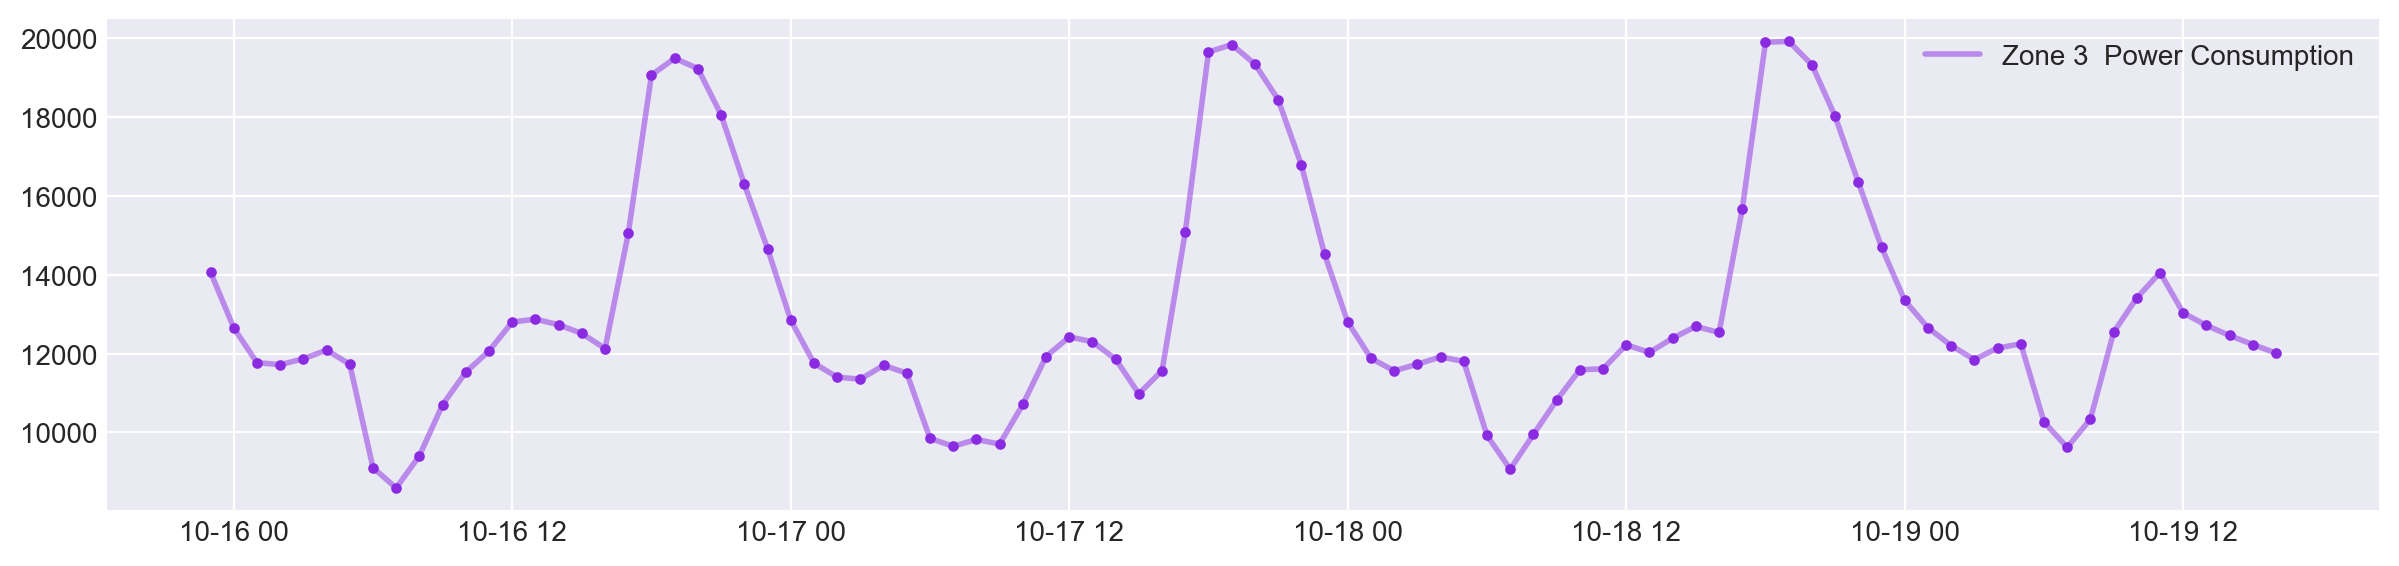

In [5]:
show_dataset(dataframe[:90], columns=["Zone 3  Power Consumption"])

In [6]:
DT_FEATURES = [
    "dayofweek",
    "quarter",
    "month",
    "year",
    "dayofyear",
    "dayofmonth",
    "weekofyear",
    "dayofweek",
    "is_week_end",
    "is_week_day",
]
CYCLIC_FEATURE = ["day", "month", "year"]
LAGS = [1, 2]
FEATURE_WINDOW_LEN = 3

TARGET_COLUMN = "Zone 3  Power Consumption"
TEST_SIZE = 30

In [7]:
print(f"dataframe shape {dataframe.shape}")

build_features = lambda df: (
    df.pipe(create_lag_feature, column=TARGET_COLUMN, lags=LAGS)
    .pipe(create_window_feature, column=TARGET_COLUMN, window_len=FEATURE_WINDOW_LEN)
    .pipe(create_datetime_feature, features_name=DT_FEATURES)
    .pipe(create_cyclic_feature, features_name=CYCLIC_FEATURE)
    .pipe(drop_null_rows)
)

df_feat = build_features(dataframe)

print(f"dataframe shape after Feature Union {df_feat.shape}", end="\n\n")

train_data, test_data = test_train_split(df_feat, test_size=TEST_SIZE)

print(f"Train Size after Test_Train Split: {train_data.shape}")
print(f"Test  Size after Test_Train Split: {test_data.shape} ", end="\n\n")

train_x, train_y = seperate_target(train_data, TARGET_COLUMN)
test_x, test_y = seperate_target(test_data, TARGET_COLUMN)

print(f"train_x shape after seperate_target {train_x.shape}")
print(f"train_y shape after seperate_target {train_y.shape}")
print(f"test_x  shape after seperate_target {test_x.shape}")
print(f"test_y  shape after seperate_target {test_y.shape}")

dataframe shape (1825, 8)
dataframe shape after Feature Union (1822, 27)

Train Size after Test_Train Split: (1792, 27)
Test  Size after Test_Train Split: (30, 27) 

train_x shape after seperate_target (1792, 26)
train_y shape after seperate_target (1792, 1)
test_x  shape after seperate_target (30, 26)
test_y  shape after seperate_target (30, 1)


In [8]:
resultsDict = {}
predictionsDF = pd.DataFrame(index=test_x.index)

### KNeighborsRegressor

In [9]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

model_name = "KNeighborsRegressor"

estimator_ = Pipeline(
    [
        ("scaler", StandardScaler()),
        (
            "regressor",
            KNeighborsRegressor(n_neighbors=2),
        ),
    ]
)

param_grid = {"regressor__n_neighbors": [2, 3, 5, 7, 12, 15]}

cross_validator = TimeSeriesSplit(n_splits=3)

gsearch = GridSearchCV(
    estimator=estimator_,
    cv=cross_validator,
    param_grid=param_grid,
    refit=True,
    verbose=3,
    n_jobs=1,
)

gsearch.fit(train_x, train_y.to_numpy().flatten())

print(gsearch.best_score_, gsearch.best_params_)

model = gsearch.best_estimator_

yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y[TARGET_COLUMN].to_numpy(), yhat)
predictionsDF[model_name] = yhat

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV 1/3] END ..........regressor__n_neighbors=2;, score=0.437 total time=   0.0s
[CV 2/3] END ..........regressor__n_neighbors=2;, score=0.603 total time=   0.0s
[CV 3/3] END ..........regressor__n_neighbors=2;, score=0.856 total time=   0.0s
[CV 1/3] END ..........regressor__n_neighbors=3;, score=0.471 total time=   0.0s
[CV 2/3] END ..........regressor__n_neighbors=3;, score=0.611 total time=   0.0s
[CV 3/3] END ..........regressor__n_neighbors=3;, score=0.863 total time=   0.0s
[CV 1/3] END ..........regressor__n_neighbors=5;, score=0.481 total time=   0.0s
[CV 2/3] END ..........regressor__n_neighbors=5;, score=0.644 total time=   0.0s
[CV 3/3] END ..........regressor__n_neighbors=5;, score=0.850 total time=   0.0s
[CV 1/3] END ..........regressor__n_neighbors=7;, score=0.473 total time=   0.0s
[CV 2/3] END ..........regressor__n_neighbors=7;, score=0.651 total time=   0.0s
[CV 3/3] END ..........regressor__n_neighbors=7;,

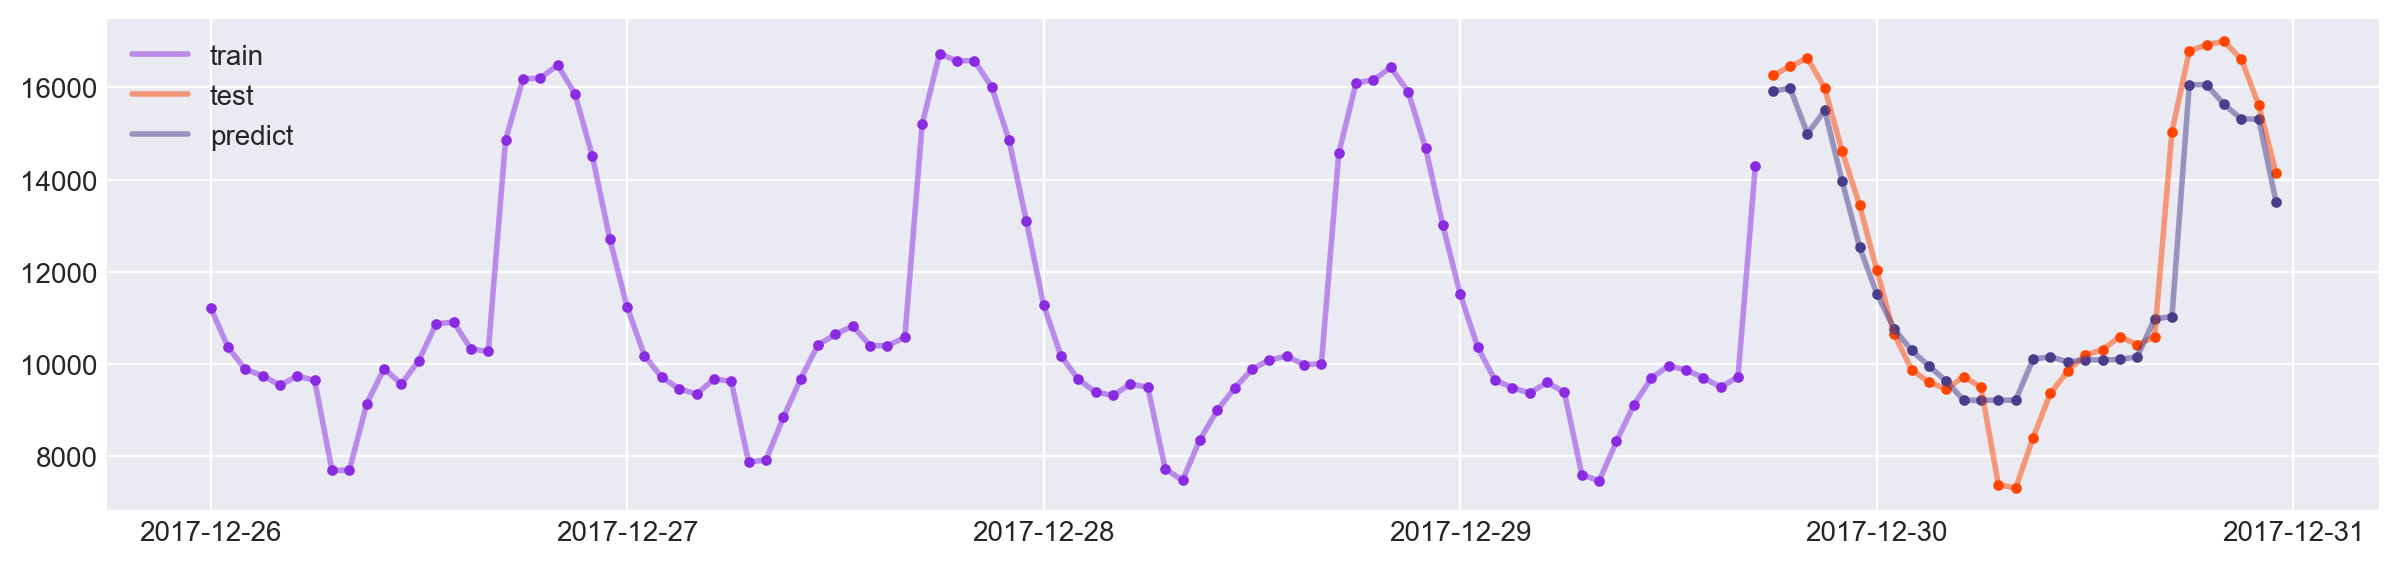

In [10]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### Ridge Model

In [11]:
from sklearn.linear_model import BayesianRidge

model, yhat, model_name = None, None, None
model_name = "BayesianRidge"

model = Pipeline(
    [
        ("scaler", StandardScaler()),
        (
            "regressor",
            BayesianRidge(fit_intercept=True, verbose=True, compute_score=True),
        ),
    ]
)


model.fit(train_x, train_y.to_numpy().flatten())
yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y[TARGET_COLUMN].to_numpy(), yhat)
predictionsDF[model_name] = yhat

Convergence after  9  iterations


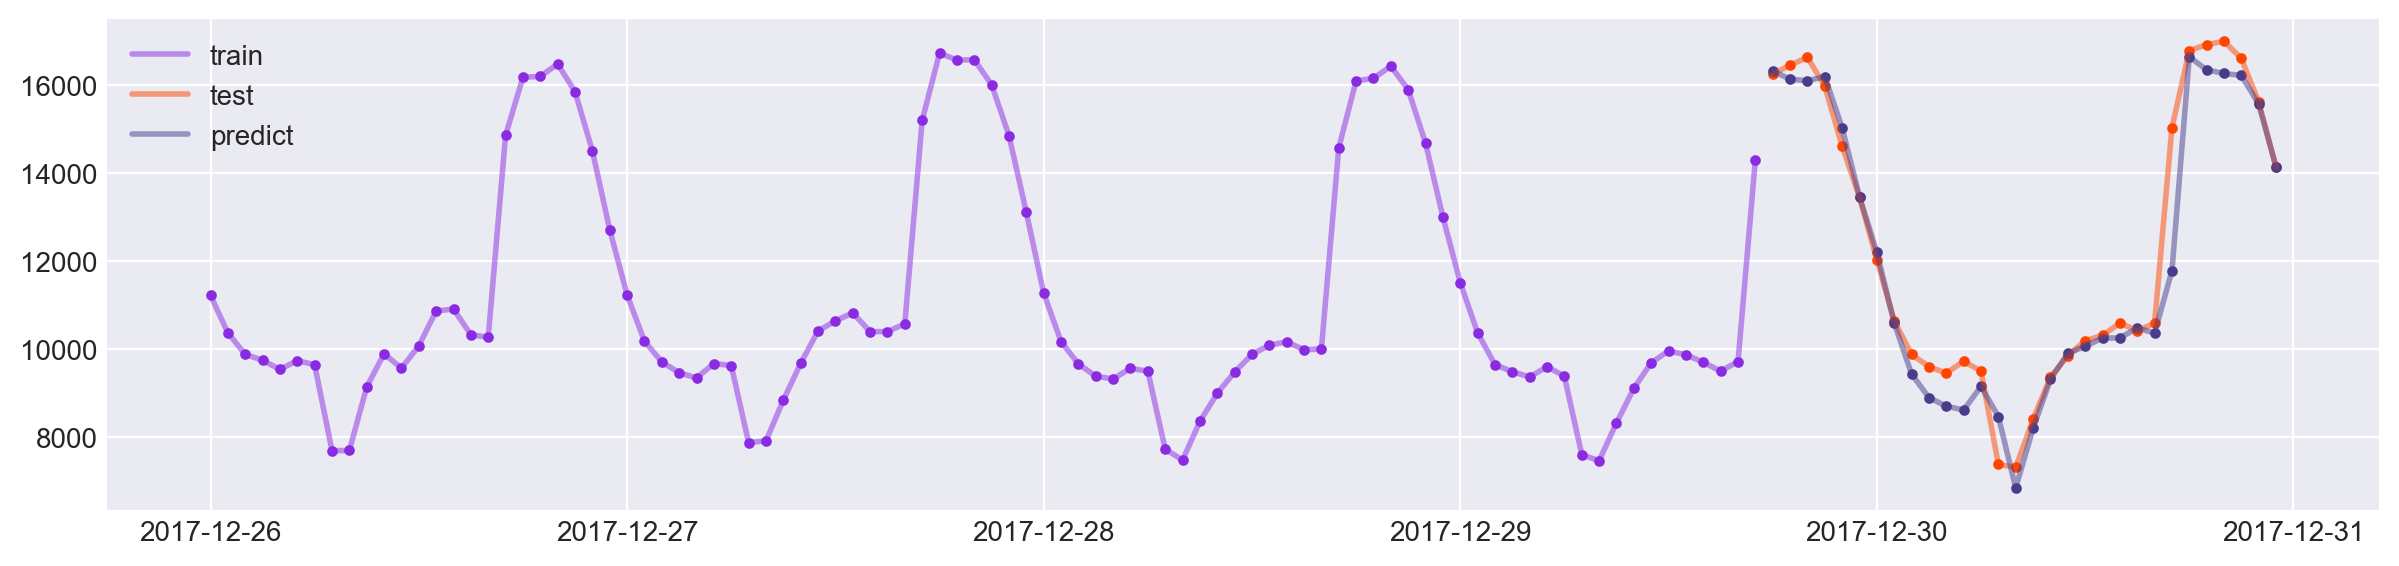

In [12]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### LassoCV Regressor

In [13]:
from sklearn.linear_model import LassoCV

model, yhat, model_name = None, None, None

model_name = "LassoCV"

model = Pipeline(
    [("scaler", StandardScaler()), ("regressor", LassoCV(fit_intercept=True))]
)

model.fit(train_x, train_y.to_numpy().flatten())
yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y[TARGET_COLUMN].to_numpy(), yhat)
predictionsDF[model_name] = yhat

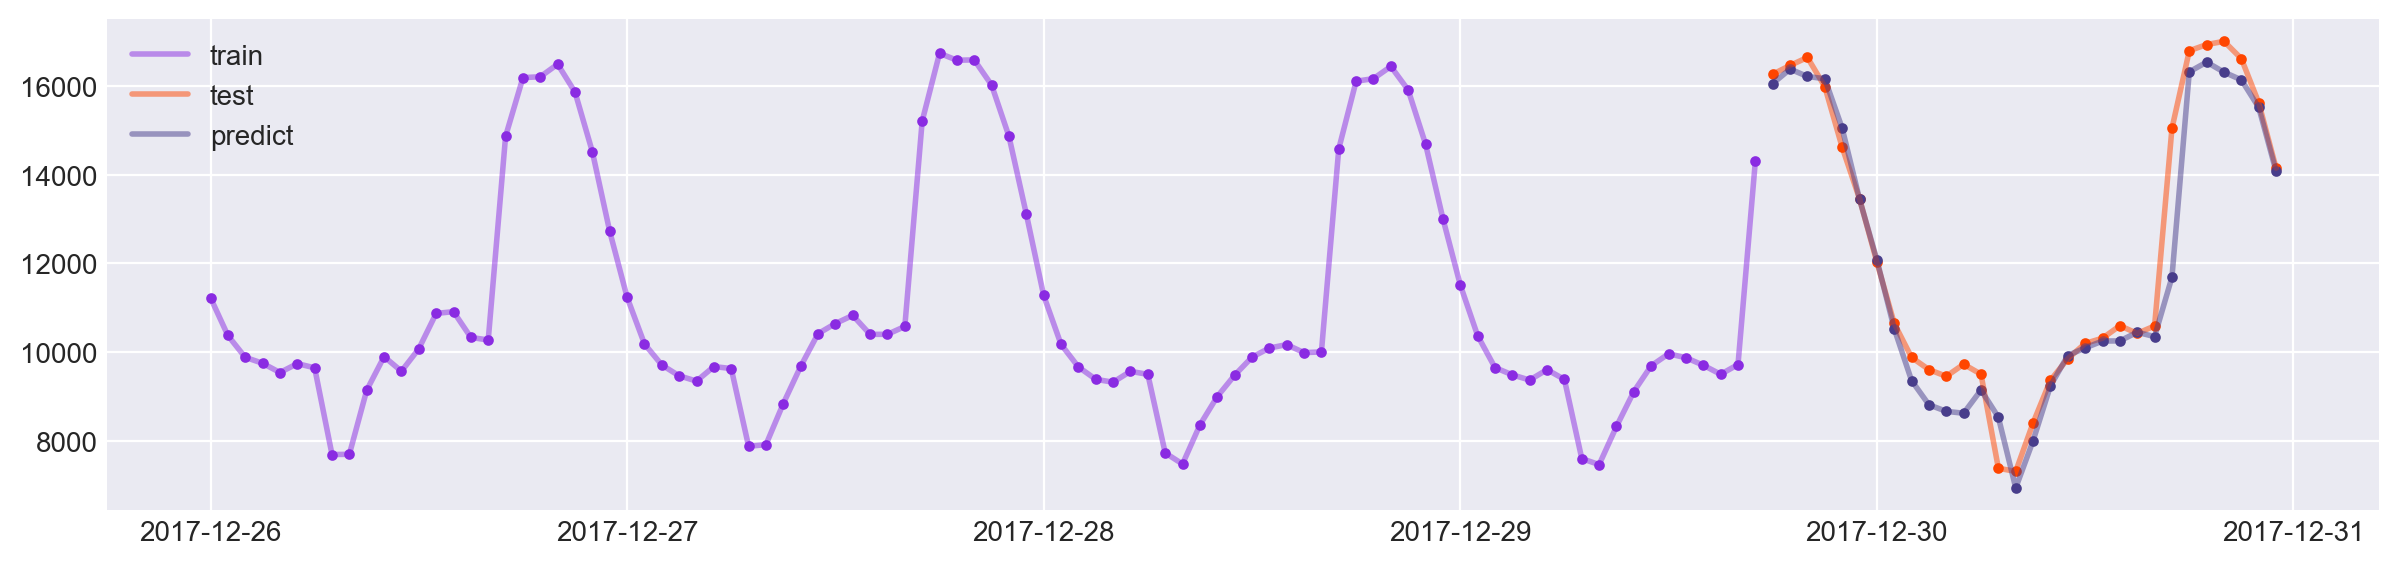

In [14]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### Random Forest Regressor

In [15]:
%%time

from sklearn.ensemble import RandomForestRegressor


model, yhat, model_name = None, None, None

model_name = "RandomForestRegressor"

# Best Params {'max_depth': 9, 'min_samples_leaf': 2, 'min_samples_split': 7, 'n_estimators': 500}

param_grid = {
    #'bootstrap': [True,False],
    # "max_depth": [7, 8, 9],
    # "min_samples_leaf": [2, 3],
    # "min_samples_split": [7, 8],
    # "n_estimators": [300, 500, 600],
    "max_depth": [9],
    "min_samples_leaf": [2],
    "min_samples_split": [7],
    "n_estimators": [500],
}

estimator_ = RandomForestRegressor(random_state=80)


cross_validator = TimeSeriesSplit(n_splits=3)

gsearch = GridSearchCV(
    estimator=estimator_,
    cv=cross_validator,
    param_grid=param_grid,
    refit=True,
    verbose=3,
    n_jobs=1,
)

# gsearch.fit(train_x_scaled, train_y.to_numpy().flatten())


gsearch.fit(train_x, train_y.to_numpy().flatten())

print(gsearch.best_score_, gsearch.best_params_)

model = gsearch.best_estimator_

yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y[TARGET_COLUMN].to_numpy(), yhat)
predictionsDF[model_name] = yhat

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END max_depth=9, min_samples_leaf=2, min_samples_split=7, n_estimators=500;, score=0.786 total time=   1.6s
[CV 2/3] END max_depth=9, min_samples_leaf=2, min_samples_split=7, n_estimators=500;, score=0.888 total time=   9.4s
[CV 3/3] END max_depth=9, min_samples_leaf=2, min_samples_split=7, n_estimators=500;, score=0.952 total time=  14.5s
0.875106469504534 {'max_depth': 9, 'min_samples_leaf': 2, 'min_samples_split': 7, 'n_estimators': 500}
CPU times: total: 26.4 s
Wall time: 46.1 s


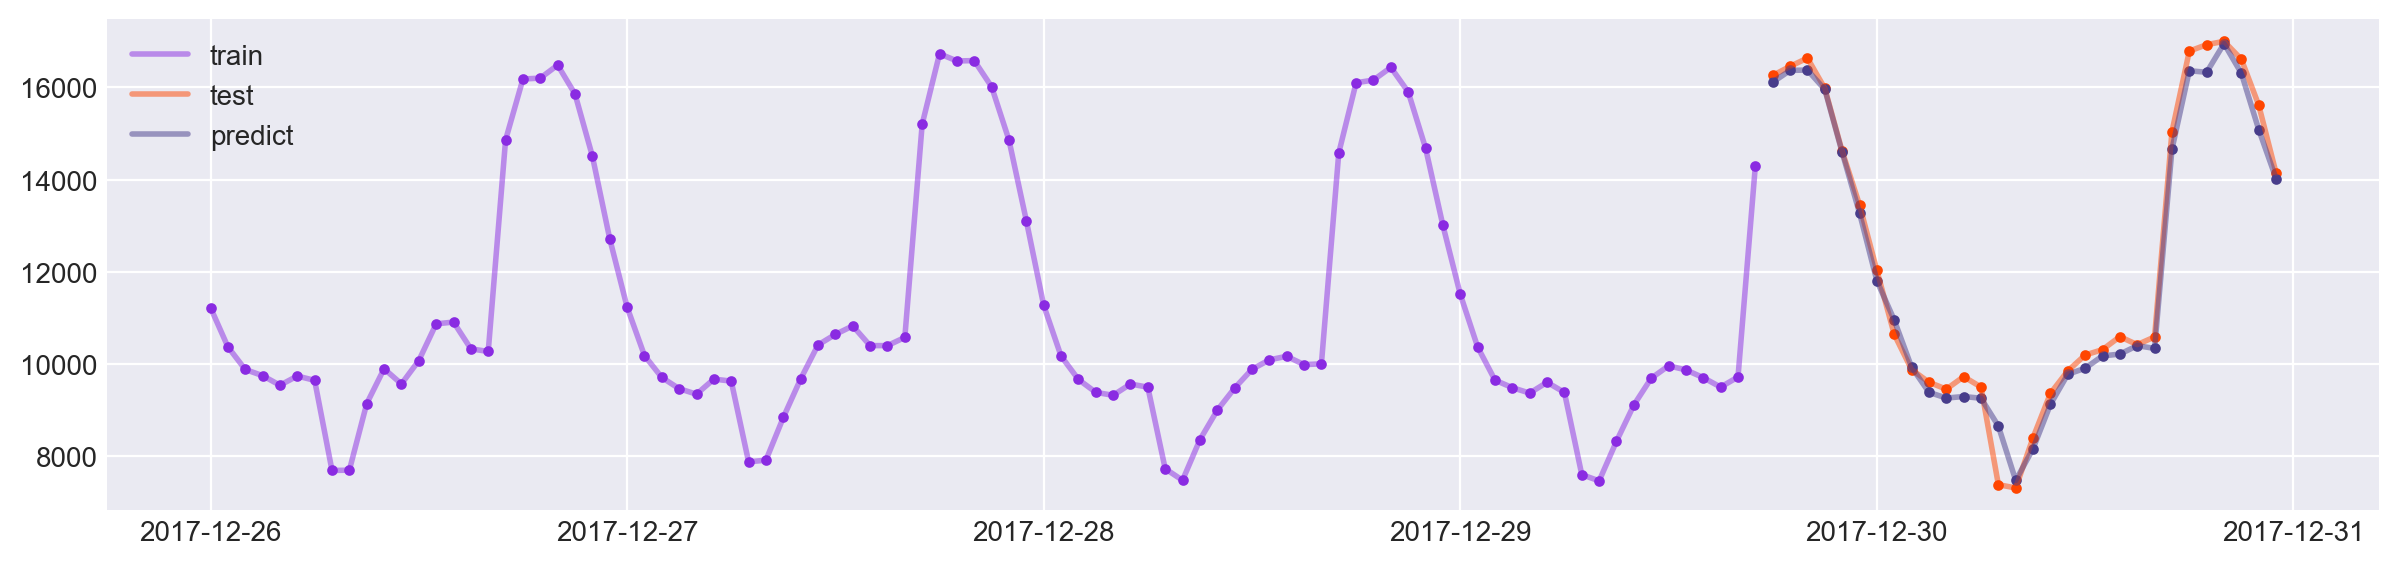

In [18]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### XGB Regressor

CPU times: total: 0 ns
Wall time: 0 ns
[0]	validation_0-mae:12015.49825	validation_1-mae:12239.57622
[1]	validation_0-mae:11896.06921	validation_1-mae:12118.94328
[2]	validation_0-mae:11777.82898	validation_1-mae:11999.03594
[3]	validation_0-mae:11660.76394	validation_1-mae:11880.77936
[4]	validation_0-mae:11544.86439	validation_1-mae:11763.23350
[5]	validation_0-mae:11430.11367	validation_1-mae:11647.33765
[6]	validation_0-mae:11316.51019	validation_1-mae:11531.30745
[7]	validation_0-mae:11204.03118	validation_1-mae:11417.69383
[8]	validation_0-mae:11092.66870	validation_1-mae:11304.03494
[9]	validation_0-mae:10982.42833	validation_1-mae:11193.17088
[10]	validation_0-mae:10873.17675	validation_1-mae:11082.78709
[11]	validation_0-mae:10765.01574	validation_1-mae:10972.72399
[12]	validation_0-mae:10658.03415	validation_1-mae:10864.51699
[13]	validation_0-mae:10552.01322	validation_1-mae:10756.63351
[14]	validation_0-mae:10447.12462	validation_1-mae:10650.80309
[15]	validation_0-mae:1034

[133]	validation_0-mae:3192.10097	validation_1-mae:3321.83078
[134]	validation_0-mae:3160.52750	validation_1-mae:3289.61053
[135]	validation_0-mae:3129.27489	validation_1-mae:3258.04510
[136]	validation_0-mae:3098.32615	validation_1-mae:3226.97342
[137]	validation_0-mae:3067.70704	validation_1-mae:3196.58745
[138]	validation_0-mae:3037.36273	validation_1-mae:3166.20046
[139]	validation_0-mae:3007.31412	validation_1-mae:3135.65833
[140]	validation_0-mae:2977.54980	validation_1-mae:3106.63242
[141]	validation_0-mae:2948.14661	validation_1-mae:3077.83454
[142]	validation_0-mae:2918.99368	validation_1-mae:3048.05282
[143]	validation_0-mae:2890.19616	validation_1-mae:3020.02523
[144]	validation_0-mae:2861.66302	validation_1-mae:2991.82842
[145]	validation_0-mae:2833.40504	validation_1-mae:2964.11266
[146]	validation_0-mae:2805.37846	validation_1-mae:2936.04320
[147]	validation_0-mae:2777.67616	validation_1-mae:2908.91971
[148]	validation_0-mae:2750.29920	validation_1-mae:2882.19849
[149]	va

[265]	validation_0-mae:894.29526	validation_1-mae:1110.13592
[266]	validation_0-mae:886.19678	validation_1-mae:1102.47454
[267]	validation_0-mae:878.18746	validation_1-mae:1094.72904
[268]	validation_0-mae:870.29791	validation_1-mae:1087.31169
[269]	validation_0-mae:862.45202	validation_1-mae:1079.71976
[270]	validation_0-mae:854.74764	validation_1-mae:1072.29295
[271]	validation_0-mae:847.15250	validation_1-mae:1064.63633
[272]	validation_0-mae:839.52815	validation_1-mae:1057.38765
[273]	validation_0-mae:832.00100	validation_1-mae:1049.03083
[274]	validation_0-mae:824.60266	validation_1-mae:1041.64246
[275]	validation_0-mae:817.21482	validation_1-mae:1034.65199
[276]	validation_0-mae:809.96541	validation_1-mae:1027.19569
[277]	validation_0-mae:802.73949	validation_1-mae:1020.86974
[278]	validation_0-mae:795.60850	validation_1-mae:1013.68426
[279]	validation_0-mae:788.58019	validation_1-mae:1007.16309
[280]	validation_0-mae:781.64846	validation_1-mae:999.84556
[281]	validation_0-mae:77

[402]	validation_0-mae:321.15329	validation_1-mae:528.46382
[403]	validation_0-mae:319.47636	validation_1-mae:526.55685
[404]	validation_0-mae:317.82437	validation_1-mae:524.67319
[405]	validation_0-mae:316.19803	validation_1-mae:522.82578
[406]	validation_0-mae:314.70303	validation_1-mae:520.58841
[407]	validation_0-mae:313.15324	validation_1-mae:518.76312
[408]	validation_0-mae:311.64265	validation_1-mae:517.10583
[409]	validation_0-mae:310.18717	validation_1-mae:515.39795
[410]	validation_0-mae:308.74181	validation_1-mae:513.81224
[411]	validation_0-mae:307.38248	validation_1-mae:511.91849
[412]	validation_0-mae:305.98289	validation_1-mae:510.57829
[413]	validation_0-mae:304.62606	validation_1-mae:508.97171
[414]	validation_0-mae:303.30757	validation_1-mae:507.11566
[415]	validation_0-mae:301.94751	validation_1-mae:504.74137
[416]	validation_0-mae:300.64650	validation_1-mae:503.13211
[417]	validation_0-mae:299.25601	validation_1-mae:501.14891
[418]	validation_0-mae:297.95846	validat

[538]	validation_0-mae:214.82492	validation_1-mae:384.55661
[539]	validation_0-mae:214.42719	validation_1-mae:384.22285
[540]	validation_0-mae:214.02729	validation_1-mae:383.79105
[541]	validation_0-mae:213.68063	validation_1-mae:383.36286
[542]	validation_0-mae:213.18634	validation_1-mae:382.76468
[543]	validation_0-mae:212.68791	validation_1-mae:382.17511
[544]	validation_0-mae:212.30041	validation_1-mae:381.87852
[545]	validation_0-mae:211.81193	validation_1-mae:381.29930
[546]	validation_0-mae:211.47939	validation_1-mae:380.85122
[547]	validation_0-mae:210.93200	validation_1-mae:380.02300
[548]	validation_0-mae:210.44580	validation_1-mae:379.52850
[549]	validation_0-mae:210.11517	validation_1-mae:379.26890
[550]	validation_0-mae:209.68696	validation_1-mae:378.57082
[551]	validation_0-mae:209.36787	validation_1-mae:378.29250
[552]	validation_0-mae:208.84183	validation_1-mae:377.49160
[553]	validation_0-mae:208.43785	validation_1-mae:376.78363
[554]	validation_0-mae:208.12864	validat

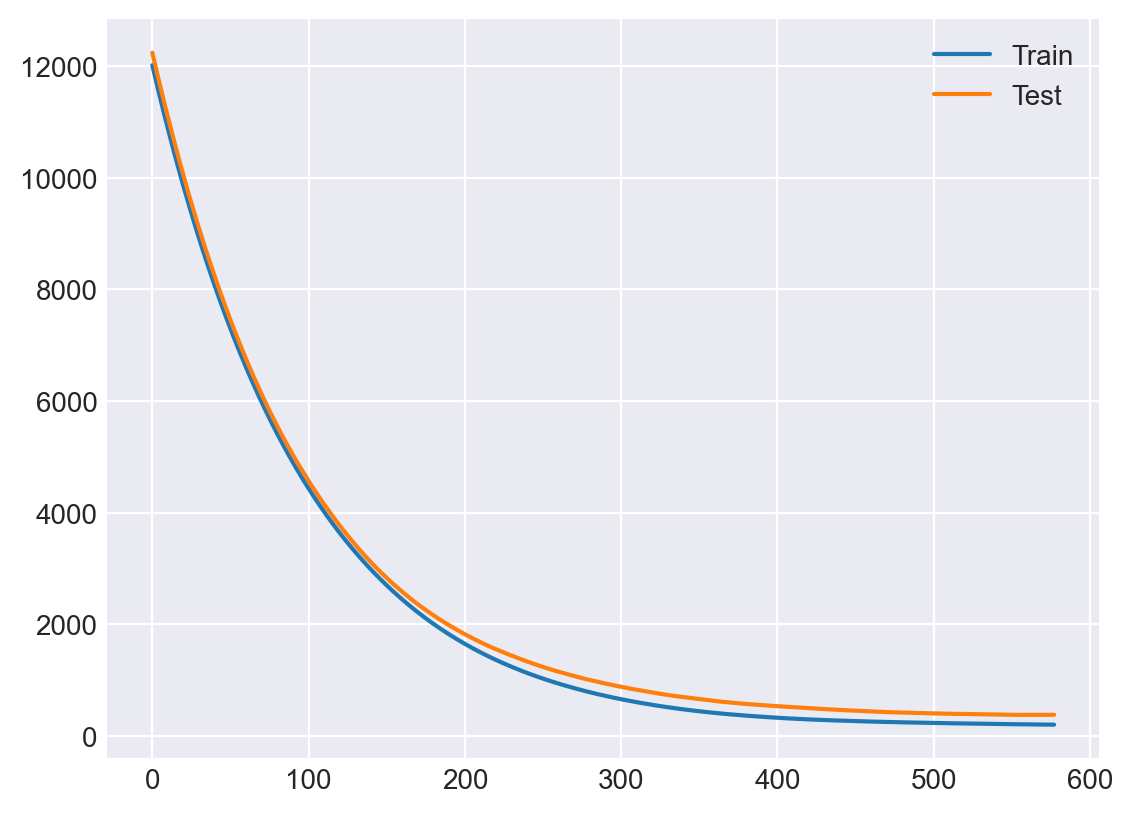

In [19]:
import xgboost as xgb

model, yhat, model_name = None, None, None

model_name = "XGBRegressor"

model = xgb.XGBRegressor(
    objective="reg:squarederror",
    n_estimators=1000,
    max_depth=6,
    learning_rate=0.01,
    tree_method="hist",
    early_stopping_rounds=20,
    eval_metric="mae",
    random_state=1,
)

%time

model.fit(
    train_x, train_y, eval_set=[(train_x, train_y), (test_x, test_y)], verbose=True
)

yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y[TARGET_COLUMN].to_numpy(), yhat)

predictionsDF[model_name] = yhat

# resultsDF.head()

fig, ax = plt.subplots()
epochs = len(model.evals_result()["validation_0"]["mae"])
x_axis = range(0, epochs)
ax.plot(x_axis, model.evals_result()["validation_0"]["mae"], label="Train")
ax.plot(x_axis, model.evals_result()["validation_1"]["mae"], label="Test")
ax.legend()

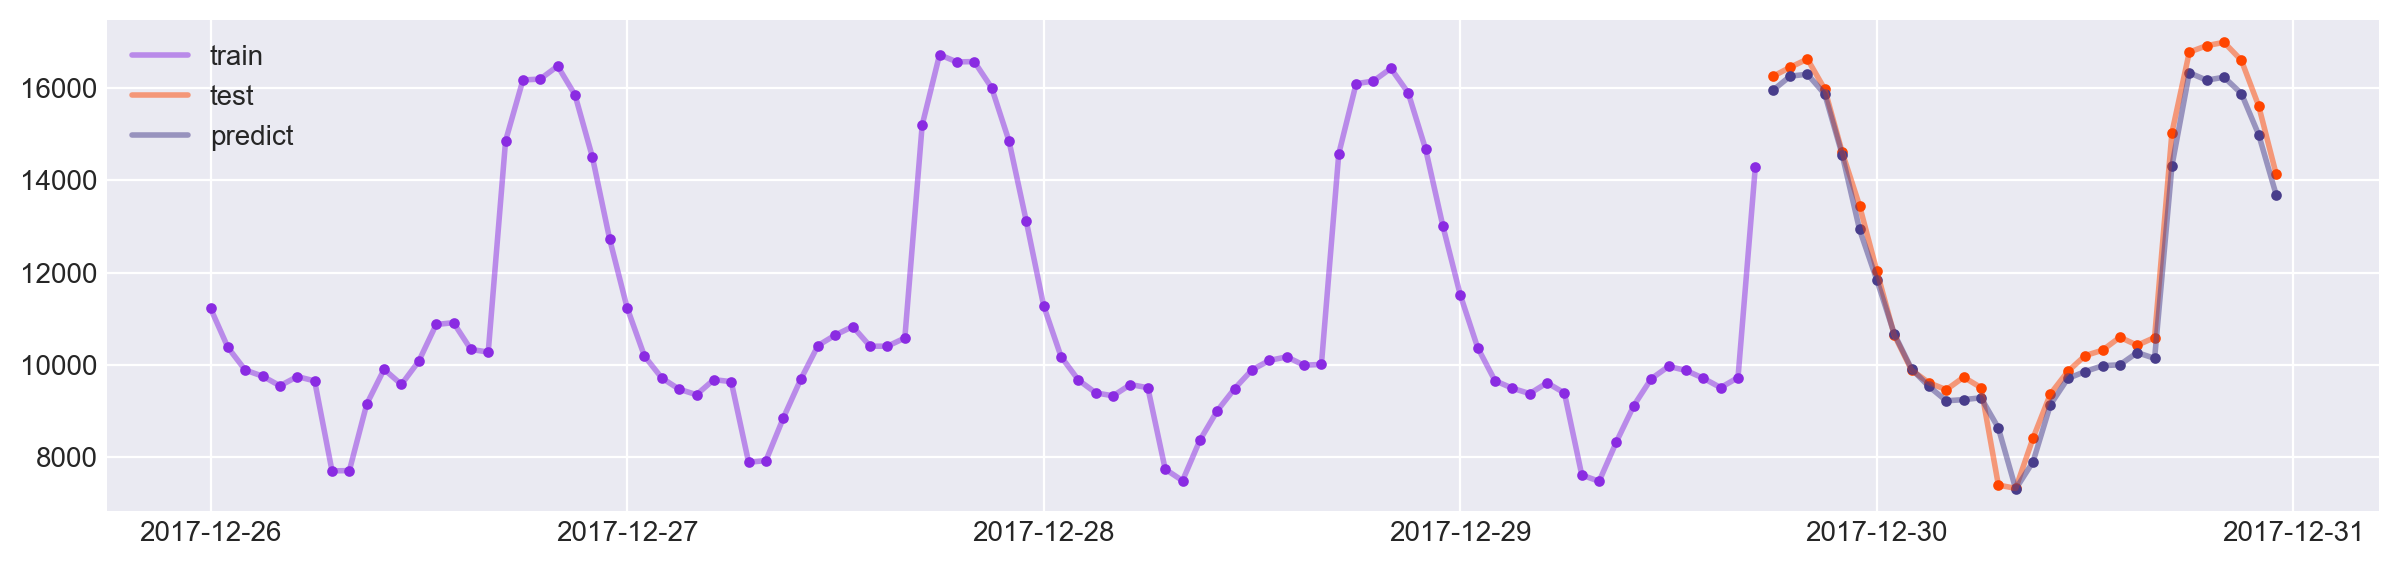

In [20]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### LGBM

In [21]:
import lightgbm as lgb

model, yhat, model_name = None, None, None

model_name = "LGBMRegressor"

hyper_params = {
    "task": "train",
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": ["mae", "l2"],
    "learning_rate": 0.005,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.7,
    "bagging_freq": 10,
    "verbose": 0,
    "max_depth": 8,
    "num_leaves": 128,
    "max_bin": 512,
    "num_iterations": 10000,
}

model = lgb.LGBMRegressor()

model.fit(
    train_x,
    train_y,
    eval_set=[(train_x, train_y), (test_x, test_y)],
    eval_metric="mae",
    callbacks=[lgb.early_stopping(stopping_rounds=5000), lgb.log_evaluation()],
)


yhat = model.predict(test_x, num_iteration=model.best_iteration_)

resultsDict[model_name] = evaluate(test_y[TARGET_COLUMN].to_numpy(), yhat)

predictionsDF[model_name] = yhat

[1]	training's l1: 2474.26	training's l2: 8.76011e+06	valid_1's l1: 2673.54	valid_1's l2: 8.54335e+06
Training until validation scores don't improve for 5000 rounds
[2]	training's l1: 2236.97	training's l2: 7.19576e+06	valid_1's l1: 2427.89	valid_1's l2: 7.09084e+06
[3]	training's l1: 2026.28	training's l2: 5.92295e+06	valid_1's l1: 2201.42	valid_1's l2: 5.8797e+06
[4]	training's l1: 1836.6	training's l2: 4.88511e+06	valid_1's l1: 2005.6	valid_1's l2: 4.91958e+06
[5]	training's l1: 1665.94	training's l2: 4.0379e+06	valid_1's l1: 1822.35	valid_1's l2: 4.09508e+06
[6]	training's l1: 1514.89	training's l2: 3.35206e+06	valid_1's l1: 1659.36	valid_1's l2: 3.4394e+06
[7]	training's l1: 1377.48	training's l2: 2.78723e+06	valid_1's l1: 1508.77	valid_1's l2: 2.879e+06
[8]	training's l1: 1255.14	training's l2: 2.32832e+06	valid_1's l1: 1378.3	valid_1's l2: 2.42764e+06
[9]	training's l1: 1143.64	training's l2: 1.95323e+06	valid_1's l1: 1253.33	valid_1's l2: 2.03985e+06
[10]	training's l1: 1045.35

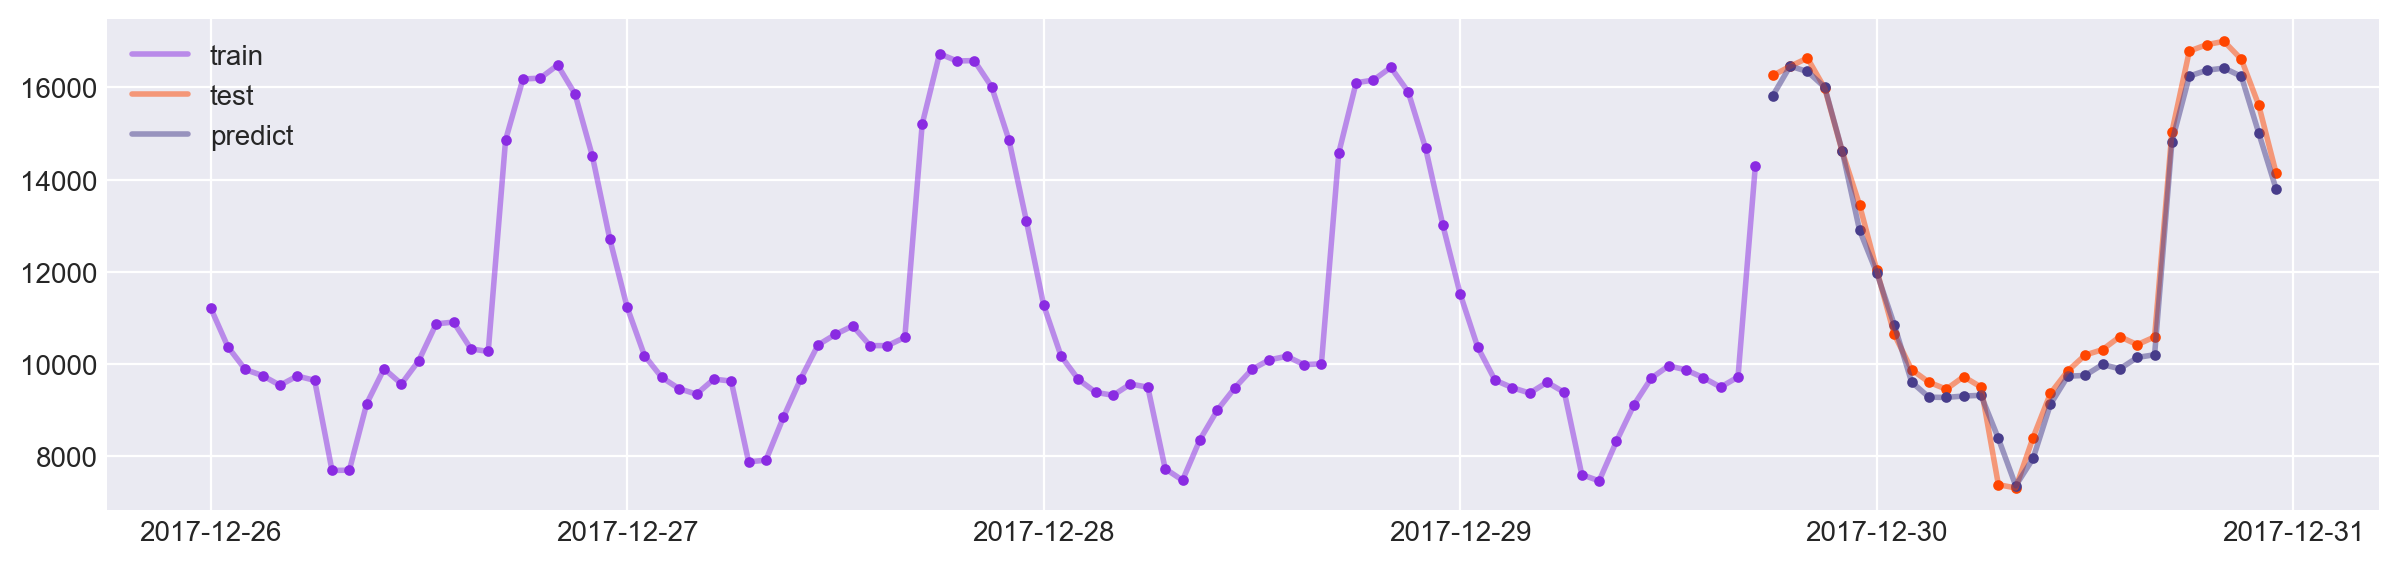

In [22]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### CatBoost

In [23]:
import catboost

model, yhat, model_name = None, None, None

model_name = "CatBoostRegressor"

model = catboost.CatBoostRegressor(learning_rate=0.1, depth=4, iterations=1000)

train_pool = catboost.Pool(train_x, train_y)
test_pool = catboost.Pool(test_x, test_y)

grid = {
    #    'learning_rate': [0.03, 0.1],
    #    'depth':[4, 6, 10],
    #    'l2_leaf_reg': [1, 3, 5, 7, 9]
    "l2_leaf_reg": [3, 5]
}

grid_search_results = model.grid_search(
    grid, train_pool, shuffle=False, verbose=3, refit=True, plot=False
)


print(grid_search_results["params"])

yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y[TARGET_COLUMN].to_numpy(), yhat)

predictionsDF[model_name] = yhat

0:	learn: 11658.6368630	test: 10137.3954894	best: 10137.3954894 (0)	total: 161ms	remaining: 2m 40s
1:	learn: 10546.6906659	test: 9183.9966253	best: 9183.9966253 (1)	total: 179ms	remaining: 1m 29s
2:	learn: 9558.9767330	test: 8306.3019714	best: 8306.3019714 (2)	total: 193ms	remaining: 1m 4s
3:	learn: 8679.9452489	test: 7470.1122412	best: 7470.1122412 (3)	total: 204ms	remaining: 50.7s
4:	learn: 7861.5773064	test: 6669.7162215	best: 6669.7162215 (4)	total: 213ms	remaining: 42.3s
5:	learn: 7147.8209338	test: 6089.6131061	best: 6089.6131061 (5)	total: 223ms	remaining: 36.9s
6:	learn: 6489.5601124	test: 5481.9159256	best: 5481.9159256 (6)	total: 232ms	remaining: 32.9s
7:	learn: 5905.2622282	test: 4971.7613915	best: 4971.7613915 (7)	total: 243ms	remaining: 30.1s
8:	learn: 5396.6304591	test: 4560.0093564	best: 4560.0093564 (8)	total: 272ms	remaining: 29.9s
9:	learn: 4923.8186669	test: 4148.3839770	best: 4148.3839770 (9)	total: 301ms	remaining: 29.8s
10:	learn: 4496.9865654	test: 3775.3629961	b

91:	learn: 652.5321392	test: 556.9025513	best: 556.7047995 (89)	total: 1.48s	remaining: 14.6s
92:	learn: 649.7060776	test: 560.5383743	best: 556.7047995 (89)	total: 1.5s	remaining: 14.6s
93:	learn: 647.6092644	test: 559.6565760	best: 556.7047995 (89)	total: 1.51s	remaining: 14.5s
94:	learn: 644.4640579	test: 558.4985489	best: 556.7047995 (89)	total: 1.52s	remaining: 14.5s
95:	learn: 640.8999150	test: 554.7670724	best: 554.7670724 (95)	total: 1.52s	remaining: 14.4s
96:	learn: 638.0125490	test: 552.4309440	best: 552.4309440 (96)	total: 1.53s	remaining: 14.3s
97:	learn: 635.2248856	test: 552.7787821	best: 552.4309440 (96)	total: 1.54s	remaining: 14.2s
98:	learn: 632.8601159	test: 551.3730055	best: 551.3730055 (98)	total: 1.56s	remaining: 14.2s
99:	learn: 627.8770239	test: 547.5311216	best: 547.5311216 (99)	total: 1.59s	remaining: 14.3s
100:	learn: 625.0543948	test: 546.7488659	best: 546.7488659 (100)	total: 1.61s	remaining: 14.3s
101:	learn: 623.4764834	test: 546.1319503	best: 546.1319503

192:	learn: 490.1912862	test: 511.1566499	best: 510.6863779 (184)	total: 2.76s	remaining: 11.5s
193:	learn: 489.2184522	test: 513.0899910	best: 510.6863779 (184)	total: 2.79s	remaining: 11.6s
194:	learn: 488.2254740	test: 512.9335399	best: 510.6863779 (184)	total: 2.82s	remaining: 11.6s
195:	learn: 487.7006369	test: 512.8598336	best: 510.6863779 (184)	total: 2.84s	remaining: 11.7s
196:	learn: 486.5971708	test: 512.9830541	best: 510.6863779 (184)	total: 2.86s	remaining: 11.7s
197:	learn: 484.8230325	test: 513.1491911	best: 510.6863779 (184)	total: 2.87s	remaining: 11.6s
198:	learn: 484.0750355	test: 512.4779478	best: 510.6863779 (184)	total: 2.88s	remaining: 11.6s
199:	learn: 483.0626670	test: 512.5827929	best: 510.6863779 (184)	total: 2.89s	remaining: 11.6s
200:	learn: 482.2968532	test: 511.8859555	best: 510.6863779 (184)	total: 2.91s	remaining: 11.6s
201:	learn: 481.7645872	test: 512.0955040	best: 510.6863779 (184)	total: 2.94s	remaining: 11.6s
202:	learn: 480.7994993	test: 512.035918

278:	learn: 422.0749841	test: 524.6795796	best: 510.3805491 (224)	total: 4.06s	remaining: 10.5s
279:	learn: 421.4569965	test: 524.9314074	best: 510.3805491 (224)	total: 4.07s	remaining: 10.5s
280:	learn: 420.7317533	test: 524.4820634	best: 510.3805491 (224)	total: 4.07s	remaining: 10.4s
281:	learn: 419.7568131	test: 524.3527306	best: 510.3805491 (224)	total: 4.07s	remaining: 10.4s
282:	learn: 419.0934186	test: 527.7494293	best: 510.3805491 (224)	total: 4.08s	remaining: 10.3s
283:	learn: 418.6122158	test: 527.8678448	best: 510.3805491 (224)	total: 4.08s	remaining: 10.3s
284:	learn: 418.0539355	test: 527.9088804	best: 510.3805491 (224)	total: 4.08s	remaining: 10.2s
285:	learn: 417.3308356	test: 527.2157023	best: 510.3805491 (224)	total: 4.08s	remaining: 10.2s
286:	learn: 416.7770963	test: 527.2471347	best: 510.3805491 (224)	total: 4.1s	remaining: 10.2s
287:	learn: 416.3142178	test: 527.2684713	best: 510.3805491 (224)	total: 4.13s	remaining: 10.2s
288:	learn: 415.3989266	test: 527.5810257

367:	learn: 374.5455564	test: 535.4155081	best: 510.3805491 (224)	total: 5.34s	remaining: 9.17s
368:	learn: 373.7417231	test: 535.0919535	best: 510.3805491 (224)	total: 5.36s	remaining: 9.16s
369:	learn: 373.2088919	test: 535.3317718	best: 510.3805491 (224)	total: 5.37s	remaining: 9.14s
370:	learn: 372.7223178	test: 535.2897485	best: 510.3805491 (224)	total: 5.38s	remaining: 9.12s
371:	learn: 372.2155705	test: 535.5129666	best: 510.3805491 (224)	total: 5.39s	remaining: 9.1s
372:	learn: 371.8645714	test: 535.4735756	best: 510.3805491 (224)	total: 5.4s	remaining: 9.07s
373:	learn: 371.3641045	test: 535.3947846	best: 510.3805491 (224)	total: 5.42s	remaining: 9.07s
374:	learn: 371.0870839	test: 535.3480202	best: 510.3805491 (224)	total: 5.45s	remaining: 9.08s
375:	learn: 370.3521792	test: 535.8728722	best: 510.3805491 (224)	total: 5.48s	remaining: 9.09s
376:	learn: 370.0249532	test: 535.8352780	best: 510.3805491 (224)	total: 5.5s	remaining: 9.09s
377:	learn: 369.1539675	test: 535.2441882	b

464:	learn: 331.4171895	test: 534.3579636	best: 510.3805491 (224)	total: 6.81s	remaining: 7.84s
465:	learn: 331.1078729	test: 534.1757248	best: 510.3805491 (224)	total: 6.82s	remaining: 7.82s
466:	learn: 330.6165921	test: 534.2447702	best: 510.3805491 (224)	total: 6.84s	remaining: 7.8s
467:	learn: 330.1812170	test: 534.1408108	best: 510.3805491 (224)	total: 6.85s	remaining: 7.79s
468:	learn: 330.0013307	test: 534.3853600	best: 510.3805491 (224)	total: 6.86s	remaining: 7.77s
469:	learn: 329.4496003	test: 534.4032726	best: 510.3805491 (224)	total: 6.87s	remaining: 7.75s
470:	learn: 328.9889463	test: 534.3464481	best: 510.3805491 (224)	total: 6.88s	remaining: 7.73s
471:	learn: 328.5065262	test: 534.3268921	best: 510.3805491 (224)	total: 6.9s	remaining: 7.72s
472:	learn: 328.1312559	test: 534.7343000	best: 510.3805491 (224)	total: 6.91s	remaining: 7.7s
473:	learn: 327.7741452	test: 534.5822481	best: 510.3805491 (224)	total: 6.92s	remaining: 7.68s
474:	learn: 327.3746381	test: 534.3068074	b

560:	learn: 297.0096713	test: 535.5056641	best: 510.3805491 (224)	total: 8.33s	remaining: 6.52s
561:	learn: 296.7896030	test: 535.4579190	best: 510.3805491 (224)	total: 8.36s	remaining: 6.52s
562:	learn: 296.5095909	test: 535.2862682	best: 510.3805491 (224)	total: 8.39s	remaining: 6.51s
563:	learn: 296.1950090	test: 535.1641620	best: 510.3805491 (224)	total: 8.4s	remaining: 6.5s
564:	learn: 296.0243665	test: 535.0094034	best: 510.3805491 (224)	total: 8.42s	remaining: 6.48s
565:	learn: 296.0023030	test: 535.0475592	best: 510.3805491 (224)	total: 8.43s	remaining: 6.47s
566:	learn: 295.6748393	test: 535.1273921	best: 510.3805491 (224)	total: 8.45s	remaining: 6.45s
567:	learn: 295.1244166	test: 535.4192876	best: 510.3805491 (224)	total: 8.46s	remaining: 6.43s
568:	learn: 294.5312923	test: 535.6512883	best: 510.3805491 (224)	total: 8.47s	remaining: 6.42s
569:	learn: 294.1661954	test: 535.4282767	best: 510.3805491 (224)	total: 8.48s	remaining: 6.4s
570:	learn: 293.7828065	test: 535.1649213	b

648:	learn: 271.7792564	test: 536.1467502	best: 510.3805491 (224)	total: 9.63s	remaining: 5.21s
649:	learn: 271.5129724	test: 536.1670234	best: 510.3805491 (224)	total: 9.67s	remaining: 5.21s
650:	learn: 271.1453951	test: 536.0894007	best: 510.3805491 (224)	total: 9.69s	remaining: 5.19s
651:	learn: 270.8834010	test: 535.9730264	best: 510.3805491 (224)	total: 9.7s	remaining: 5.18s
652:	learn: 270.5979355	test: 535.9008385	best: 510.3805491 (224)	total: 9.72s	remaining: 5.17s
653:	learn: 270.3365081	test: 535.8271851	best: 510.3805491 (224)	total: 9.74s	remaining: 5.15s
654:	learn: 270.0026663	test: 535.7715270	best: 510.3805491 (224)	total: 9.75s	remaining: 5.14s
655:	learn: 269.8476774	test: 535.6203836	best: 510.3805491 (224)	total: 9.77s	remaining: 5.12s
656:	learn: 269.5211880	test: 535.5444026	best: 510.3805491 (224)	total: 9.78s	remaining: 5.11s
657:	learn: 269.2925948	test: 535.5326432	best: 510.3805491 (224)	total: 9.79s	remaining: 5.09s
658:	learn: 268.8368290	test: 535.7199878

743:	learn: 248.2673884	test: 536.6868922	best: 510.3805491 (224)	total: 11.2s	remaining: 3.85s
744:	learn: 248.0919889	test: 536.7568413	best: 510.3805491 (224)	total: 11.2s	remaining: 3.84s
745:	learn: 247.8584339	test: 536.8665438	best: 510.3805491 (224)	total: 11.2s	remaining: 3.83s
746:	learn: 247.6368450	test: 537.1271522	best: 510.3805491 (224)	total: 11.3s	remaining: 3.81s
747:	learn: 247.3444191	test: 536.9591091	best: 510.3805491 (224)	total: 11.3s	remaining: 3.79s
748:	learn: 247.0471596	test: 536.7604378	best: 510.3805491 (224)	total: 11.3s	remaining: 3.78s
749:	learn: 246.9166649	test: 536.8010125	best: 510.3805491 (224)	total: 11.3s	remaining: 3.76s
750:	learn: 246.6637878	test: 536.8227281	best: 510.3805491 (224)	total: 11.3s	remaining: 3.75s
751:	learn: 246.2898238	test: 537.0373364	best: 510.3805491 (224)	total: 11.4s	remaining: 3.74s
752:	learn: 245.7316230	test: 537.1411227	best: 510.3805491 (224)	total: 11.4s	remaining: 3.73s
753:	learn: 245.6613443	test: 537.224200

833:	learn: 228.3761096	test: 539.5310493	best: 510.3805491 (224)	total: 12.5s	remaining: 2.49s
834:	learn: 228.1132219	test: 539.5758829	best: 510.3805491 (224)	total: 12.5s	remaining: 2.48s
835:	learn: 227.7350533	test: 539.5493453	best: 510.3805491 (224)	total: 12.6s	remaining: 2.47s
836:	learn: 227.4440768	test: 539.4372613	best: 510.3805491 (224)	total: 12.6s	remaining: 2.45s
837:	learn: 227.2277466	test: 539.3510806	best: 510.3805491 (224)	total: 12.6s	remaining: 2.44s
838:	learn: 227.1548379	test: 539.4122597	best: 510.3805491 (224)	total: 12.6s	remaining: 2.42s
839:	learn: 227.0023562	test: 539.4162893	best: 510.3805491 (224)	total: 12.6s	remaining: 2.4s
840:	learn: 226.8391513	test: 539.3372651	best: 510.3805491 (224)	total: 12.6s	remaining: 2.39s
841:	learn: 226.6634465	test: 539.3740286	best: 510.3805491 (224)	total: 12.6s	remaining: 2.37s
842:	learn: 226.2882994	test: 539.3044453	best: 510.3805491 (224)	total: 12.7s	remaining: 2.36s
843:	learn: 226.0720475	test: 539.7964580

926:	learn: 208.7298797	test: 540.0536702	best: 510.3805491 (224)	total: 14s	remaining: 1.1s
927:	learn: 208.5774814	test: 539.8552744	best: 510.3805491 (224)	total: 14s	remaining: 1.09s
928:	learn: 208.4148714	test: 539.8767318	best: 510.3805491 (224)	total: 14s	remaining: 1.07s
929:	learn: 208.1857923	test: 539.9756358	best: 510.3805491 (224)	total: 14s	remaining: 1.06s
930:	learn: 207.9733746	test: 539.9341962	best: 510.3805491 (224)	total: 14s	remaining: 1.04s
931:	learn: 207.8824129	test: 539.8935195	best: 510.3805491 (224)	total: 14s	remaining: 1.02s
932:	learn: 207.7897517	test: 539.8914139	best: 510.3805491 (224)	total: 14.1s	remaining: 1.01s
933:	learn: 207.4695869	test: 539.7387090	best: 510.3805491 (224)	total: 14.1s	remaining: 993ms
934:	learn: 207.3735220	test: 539.6254781	best: 510.3805491 (224)	total: 14.1s	remaining: 977ms
935:	learn: 207.0970417	test: 539.6086452	best: 510.3805491 (224)	total: 14.1s	remaining: 963ms
936:	learn: 206.9517635	test: 539.4990177	best: 510.3

11:	learn: 4200.5111772	test: 3546.8492484	best: 3546.8492484 (11)	total: 185ms	remaining: 15.2s
12:	learn: 3839.1557598	test: 3182.8372734	best: 3182.8372734 (12)	total: 200ms	remaining: 15.2s
13:	learn: 3512.4539238	test: 2865.6077840	best: 2865.6077840 (13)	total: 227ms	remaining: 16s
14:	learn: 3228.4219146	test: 2573.1228057	best: 2573.1228057 (14)	total: 254ms	remaining: 16.7s
15:	learn: 2976.0388625	test: 2365.2126884	best: 2365.2126884 (15)	total: 281ms	remaining: 17.3s
16:	learn: 2757.6083109	test: 2128.6188173	best: 2128.6188173 (16)	total: 308ms	remaining: 17.8s
17:	learn: 2553.7381231	test: 1909.4914315	best: 1909.4914315 (17)	total: 320ms	remaining: 17.5s
18:	learn: 2364.8900016	test: 1731.4255977	best: 1731.4255977 (18)	total: 332ms	remaining: 17.1s
19:	learn: 2206.6304908	test: 1599.6715570	best: 1599.6715570 (19)	total: 357ms	remaining: 17.5s
20:	learn: 2065.4558999	test: 1479.2359809	best: 1479.2359809 (20)	total: 386ms	remaining: 18s
21:	learn: 1936.4252910	test: 1381

104:	learn: 642.8223514	test: 557.7678488	best: 557.7678488 (104)	total: 1.71s	remaining: 14.6s
105:	learn: 640.4109015	test: 557.9206152	best: 557.7678488 (104)	total: 1.72s	remaining: 14.5s
106:	learn: 638.0402296	test: 555.8730077	best: 555.8730077 (106)	total: 1.72s	remaining: 14.4s
107:	learn: 636.1308093	test: 555.5178511	best: 555.5178511 (107)	total: 1.73s	remaining: 14.3s
108:	learn: 634.0560209	test: 555.6195090	best: 555.5178511 (107)	total: 1.73s	remaining: 14.1s
109:	learn: 632.4537352	test: 556.1439858	best: 555.5178511 (107)	total: 1.74s	remaining: 14.1s
110:	learn: 630.4865770	test: 555.5821010	best: 555.5178511 (107)	total: 1.76s	remaining: 14.1s
111:	learn: 628.7522496	test: 554.2225166	best: 554.2225166 (111)	total: 1.82s	remaining: 14.4s
112:	learn: 626.8801692	test: 552.5449363	best: 552.5449363 (112)	total: 1.84s	remaining: 14.5s
113:	learn: 625.4615425	test: 552.2116407	best: 552.2116407 (113)	total: 1.86s	remaining: 14.4s
114:	learn: 623.8726381	test: 552.460711

192:	learn: 512.2887478	test: 528.8506089	best: 528.3388016 (188)	total: 3.25s	remaining: 13.6s
193:	learn: 511.6997155	test: 529.0370565	best: 528.3388016 (188)	total: 3.28s	remaining: 13.6s
194:	learn: 511.2580440	test: 528.7210243	best: 528.3388016 (188)	total: 3.3s	remaining: 13.6s
195:	learn: 511.0007824	test: 528.7776358	best: 528.3388016 (188)	total: 3.31s	remaining: 13.6s
196:	learn: 509.0476754	test: 528.2748036	best: 528.2748036 (196)	total: 3.32s	remaining: 13.5s
197:	learn: 506.9554629	test: 528.1107161	best: 528.1107161 (197)	total: 3.33s	remaining: 13.5s
198:	learn: 505.9477032	test: 528.3062802	best: 528.1107161 (197)	total: 3.34s	remaining: 13.5s
199:	learn: 505.1352346	test: 526.3186409	best: 526.3186409 (199)	total: 3.36s	remaining: 13.4s
200:	learn: 504.3982616	test: 526.1540470	best: 526.1540470 (200)	total: 3.4s	remaining: 13.5s
201:	learn: 503.4528646	test: 526.1858568	best: 526.1540470 (200)	total: 3.43s	remaining: 13.5s
202:	learn: 502.0829964	test: 525.7835034	

288:	learn: 440.3927784	test: 529.5459038	best: 521.7322221 (257)	total: 4.72s	remaining: 11.6s
289:	learn: 439.8315735	test: 529.2661971	best: 521.7322221 (257)	total: 4.73s	remaining: 11.6s
290:	learn: 439.3723932	test: 529.3977714	best: 521.7322221 (257)	total: 4.73s	remaining: 11.5s
291:	learn: 438.9625456	test: 529.1328437	best: 521.7322221 (257)	total: 4.73s	remaining: 11.5s
292:	learn: 437.7074448	test: 528.8772554	best: 521.7322221 (257)	total: 4.74s	remaining: 11.4s
293:	learn: 437.0105578	test: 528.8692010	best: 521.7322221 (257)	total: 4.74s	remaining: 11.4s
294:	learn: 436.4025974	test: 529.8213467	best: 521.7322221 (257)	total: 4.75s	remaining: 11.3s
295:	learn: 436.2342844	test: 529.7436175	best: 521.7322221 (257)	total: 4.75s	remaining: 11.3s
296:	learn: 435.4009187	test: 529.9903242	best: 521.7322221 (257)	total: 4.75s	remaining: 11.2s
297:	learn: 434.6211832	test: 529.8178779	best: 521.7322221 (257)	total: 4.75s	remaining: 11.2s
298:	learn: 433.8070249	test: 529.193199

376:	learn: 396.1456825	test: 542.3822283	best: 521.7322221 (257)	total: 6.24s	remaining: 10.3s
377:	learn: 395.5406076	test: 542.6379442	best: 521.7322221 (257)	total: 6.26s	remaining: 10.3s
378:	learn: 395.0826781	test: 542.4250749	best: 521.7322221 (257)	total: 6.28s	remaining: 10.3s
379:	learn: 394.5759203	test: 542.2394772	best: 521.7322221 (257)	total: 6.3s	remaining: 10.3s
380:	learn: 393.9051760	test: 541.4790951	best: 521.7322221 (257)	total: 6.34s	remaining: 10.3s
381:	learn: 393.6260072	test: 541.7568470	best: 521.7322221 (257)	total: 6.37s	remaining: 10.3s
382:	learn: 393.0585483	test: 541.3485578	best: 521.7322221 (257)	total: 6.38s	remaining: 10.3s
383:	learn: 392.9528227	test: 541.3232269	best: 521.7322221 (257)	total: 6.39s	remaining: 10.3s
384:	learn: 392.7147796	test: 541.3856020	best: 521.7322221 (257)	total: 6.41s	remaining: 10.2s
385:	learn: 391.8746780	test: 540.6280507	best: 521.7322221 (257)	total: 6.44s	remaining: 10.2s
386:	learn: 391.2754752	test: 540.0083053

489:	learn: 349.3319040	test: 541.8857521	best: 521.7322221 (257)	total: 7.99s	remaining: 8.32s
490:	learn: 348.9165732	test: 541.5530824	best: 521.7322221 (257)	total: 8s	remaining: 8.29s
491:	learn: 348.4795087	test: 541.4902703	best: 521.7322221 (257)	total: 8s	remaining: 8.26s
492:	learn: 348.2296349	test: 541.5479748	best: 521.7322221 (257)	total: 8s	remaining: 8.23s
493:	learn: 347.9411864	test: 541.4720469	best: 521.7322221 (257)	total: 8.01s	remaining: 8.21s
494:	learn: 347.8868653	test: 541.4723536	best: 521.7322221 (257)	total: 8.03s	remaining: 8.19s
495:	learn: 347.7602122	test: 541.4579287	best: 521.7322221 (257)	total: 8.05s	remaining: 8.18s
496:	learn: 347.4791945	test: 541.9912408	best: 521.7322221 (257)	total: 8.08s	remaining: 8.17s
497:	learn: 346.8617853	test: 542.1430748	best: 521.7322221 (257)	total: 8.11s	remaining: 8.17s
498:	learn: 346.6197495	test: 542.3024890	best: 521.7322221 (257)	total: 8.14s	remaining: 8.17s
499:	learn: 346.3256511	test: 542.3019072	best: 5

584:	learn: 318.9720708	test: 544.8651744	best: 521.7322221 (257)	total: 10s	remaining: 7.1s
585:	learn: 318.5450282	test: 544.8376769	best: 521.7322221 (257)	total: 10s	remaining: 7.09s
586:	learn: 318.1151056	test: 544.9305589	best: 521.7322221 (257)	total: 10.1s	remaining: 7.08s
587:	learn: 317.7644760	test: 544.9324740	best: 521.7322221 (257)	total: 10.1s	remaining: 7.07s
588:	learn: 317.2915323	test: 544.3156106	best: 521.7322221 (257)	total: 10.1s	remaining: 7.05s
589:	learn: 316.9742248	test: 544.3774436	best: 521.7322221 (257)	total: 10.1s	remaining: 7.03s
590:	learn: 316.1549213	test: 544.3137569	best: 521.7322221 (257)	total: 10.1s	remaining: 7.01s
591:	learn: 315.7738195	test: 544.3928384	best: 521.7322221 (257)	total: 10.1s	remaining: 6.99s
592:	learn: 315.4742960	test: 544.2542833	best: 521.7322221 (257)	total: 10.2s	remaining: 6.97s
593:	learn: 315.1730064	test: 544.2999044	best: 521.7322221 (257)	total: 10.2s	remaining: 6.96s
594:	learn: 314.8975327	test: 544.3154450	bes

678:	learn: 289.6048445	test: 541.1754223	best: 521.7322221 (257)	total: 11.7s	remaining: 5.55s
679:	learn: 289.2246331	test: 541.5702663	best: 521.7322221 (257)	total: 11.8s	remaining: 5.54s
680:	learn: 288.8437063	test: 541.7163162	best: 521.7322221 (257)	total: 11.8s	remaining: 5.52s
681:	learn: 288.8291519	test: 541.7570892	best: 521.7322221 (257)	total: 11.8s	remaining: 5.5s
682:	learn: 288.5761876	test: 541.4945923	best: 521.7322221 (257)	total: 11.8s	remaining: 5.49s
683:	learn: 288.1196835	test: 541.4702954	best: 521.7322221 (257)	total: 11.8s	remaining: 5.47s
684:	learn: 287.9522070	test: 541.4953242	best: 521.7322221 (257)	total: 11.9s	remaining: 5.46s
685:	learn: 287.6344580	test: 541.9256402	best: 521.7322221 (257)	total: 11.9s	remaining: 5.45s
686:	learn: 287.4733148	test: 542.0545367	best: 521.7322221 (257)	total: 11.9s	remaining: 5.43s
687:	learn: 287.0789332	test: 542.2056070	best: 521.7322221 (257)	total: 11.9s	remaining: 5.41s
688:	learn: 287.0718675	test: 542.3043602

767:	learn: 265.5029747	test: 547.8618667	best: 521.7322221 (257)	total: 13.5s	remaining: 4.08s
768:	learn: 265.3309488	test: 547.8016176	best: 521.7322221 (257)	total: 13.5s	remaining: 4.07s
769:	learn: 265.2127793	test: 547.8440520	best: 521.7322221 (257)	total: 13.6s	remaining: 4.05s
770:	learn: 264.8981008	test: 547.6909761	best: 521.7322221 (257)	total: 13.6s	remaining: 4.03s
771:	learn: 264.6251959	test: 548.2851206	best: 521.7322221 (257)	total: 13.6s	remaining: 4.01s
772:	learn: 264.6113065	test: 548.3463913	best: 521.7322221 (257)	total: 13.6s	remaining: 3.99s
773:	learn: 264.4183274	test: 548.1159023	best: 521.7322221 (257)	total: 13.6s	remaining: 3.98s
774:	learn: 264.2127174	test: 547.9794254	best: 521.7322221 (257)	total: 13.7s	remaining: 3.96s
775:	learn: 264.0764603	test: 548.0444288	best: 521.7322221 (257)	total: 13.7s	remaining: 3.95s
776:	learn: 263.7933442	test: 547.9219686	best: 521.7322221 (257)	total: 13.7s	remaining: 3.93s
777:	learn: 263.6183300	test: 547.881574

853:	learn: 246.9522057	test: 547.8887294	best: 521.7322221 (257)	total: 14.8s	remaining: 2.53s
854:	learn: 246.6441830	test: 547.8527375	best: 521.7322221 (257)	total: 14.8s	remaining: 2.51s
855:	learn: 246.4104178	test: 547.9070200	best: 521.7322221 (257)	total: 14.8s	remaining: 2.49s
856:	learn: 246.0354835	test: 547.8115002	best: 521.7322221 (257)	total: 14.8s	remaining: 2.47s
857:	learn: 245.6986384	test: 547.9379774	best: 521.7322221 (257)	total: 14.8s	remaining: 2.45s
858:	learn: 245.6121086	test: 547.7936438	best: 521.7322221 (257)	total: 14.8s	remaining: 2.44s
859:	learn: 245.4146799	test: 547.8081032	best: 521.7322221 (257)	total: 14.8s	remaining: 2.42s
860:	learn: 245.0932829	test: 547.8960938	best: 521.7322221 (257)	total: 14.8s	remaining: 2.4s
861:	learn: 244.9342429	test: 547.7307626	best: 521.7322221 (257)	total: 14.8s	remaining: 2.38s
862:	learn: 244.5253723	test: 547.3620481	best: 521.7322221 (257)	total: 14.8s	remaining: 2.36s
863:	learn: 244.5136085	test: 547.3934524

946:	learn: 227.1432288	test: 548.3636543	best: 521.7322221 (257)	total: 16.4s	remaining: 917ms
947:	learn: 226.9078345	test: 548.1787196	best: 521.7322221 (257)	total: 16.4s	remaining: 899ms
948:	learn: 226.7281663	test: 548.2921460	best: 521.7322221 (257)	total: 16.4s	remaining: 881ms
949:	learn: 226.4844082	test: 548.6891653	best: 521.7322221 (257)	total: 16.4s	remaining: 863ms
950:	learn: 226.2772548	test: 548.7807009	best: 521.7322221 (257)	total: 16.4s	remaining: 845ms
951:	learn: 226.0226633	test: 548.7541754	best: 521.7322221 (257)	total: 16.4s	remaining: 827ms
952:	learn: 225.8359588	test: 548.8035556	best: 521.7322221 (257)	total: 16.4s	remaining: 810ms
953:	learn: 225.7313304	test: 548.5775788	best: 521.7322221 (257)	total: 16.4s	remaining: 793ms
954:	learn: 225.4525930	test: 548.4712009	best: 521.7322221 (257)	total: 16.5s	remaining: 776ms
955:	learn: 225.4130072	test: 548.4798125	best: 521.7322221 (257)	total: 16.5s	remaining: 759ms
956:	learn: 225.2581111	test: 548.384942

47:	learn: 733.2919628	test: 1347.3214847	best: 1347.3214847 (47)	total: 740ms	remaining: 14.7s
48:	learn: 727.7507192	test: 1340.3021054	best: 1340.3021054 (48)	total: 767ms	remaining: 14.9s
49:	learn: 716.8284339	test: 1332.2884528	best: 1332.2884528 (49)	total: 784ms	remaining: 14.9s
50:	learn: 710.9150797	test: 1322.5021981	best: 1322.5021981 (50)	total: 799ms	remaining: 14.9s
51:	learn: 705.3113481	test: 1316.1070462	best: 1316.1070462 (51)	total: 813ms	remaining: 14.8s
52:	learn: 699.9210258	test: 1314.4676153	best: 1314.4676153 (52)	total: 824ms	remaining: 14.7s
53:	learn: 694.9351662	test: 1305.9167813	best: 1305.9167813 (53)	total: 835ms	remaining: 14.6s
54:	learn: 690.9101365	test: 1298.6613178	best: 1298.6613178 (54)	total: 844ms	remaining: 14.5s
55:	learn: 683.9959397	test: 1295.9495914	best: 1295.9495914 (55)	total: 853ms	remaining: 14.4s
56:	learn: 677.1347657	test: 1290.0771095	best: 1290.0771095 (56)	total: 864ms	remaining: 14.3s
57:	learn: 674.8803580	test: 1290.628564

141:	learn: 474.7369238	test: 1260.2452512	best: 1252.3978151 (128)	total: 2.25s	remaining: 13.6s
142:	learn: 472.8972106	test: 1260.0637480	best: 1252.3978151 (128)	total: 2.25s	remaining: 13.5s
143:	learn: 471.8682218	test: 1260.7287218	best: 1252.3978151 (128)	total: 2.25s	remaining: 13.4s
144:	learn: 470.5025006	test: 1260.8741492	best: 1252.3978151 (128)	total: 2.26s	remaining: 13.3s
145:	learn: 469.7014005	test: 1260.8296220	best: 1252.3978151 (128)	total: 2.27s	remaining: 13.3s
146:	learn: 468.5019944	test: 1263.7409695	best: 1252.3978151 (128)	total: 2.27s	remaining: 13.2s
147:	learn: 466.8736764	test: 1262.2750922	best: 1252.3978151 (128)	total: 2.28s	remaining: 13.2s
148:	learn: 465.6405099	test: 1265.4719113	best: 1252.3978151 (128)	total: 2.29s	remaining: 13.1s
149:	learn: 463.8538462	test: 1265.7868237	best: 1252.3978151 (128)	total: 2.31s	remaining: 13.1s
150:	learn: 463.0400171	test: 1265.7877468	best: 1252.3978151 (128)	total: 2.31s	remaining: 13s
151:	learn: 461.306326

229:	learn: 382.5021894	test: 1249.8447692	best: 1247.8260913 (227)	total: 3.5s	remaining: 11.7s
230:	learn: 382.4308232	test: 1249.7192782	best: 1247.8260913 (227)	total: 3.52s	remaining: 11.7s
231:	learn: 381.1652098	test: 1249.7911654	best: 1247.8260913 (227)	total: 3.56s	remaining: 11.8s
232:	learn: 380.4406818	test: 1249.7450598	best: 1247.8260913 (227)	total: 3.58s	remaining: 11.8s
233:	learn: 378.9842944	test: 1249.7673246	best: 1247.8260913 (227)	total: 3.59s	remaining: 11.8s
234:	learn: 377.9459419	test: 1251.1419492	best: 1247.8260913 (227)	total: 3.61s	remaining: 11.7s
235:	learn: 376.6441168	test: 1251.4011797	best: 1247.8260913 (227)	total: 3.62s	remaining: 11.7s
236:	learn: 375.3478595	test: 1251.7264210	best: 1247.8260913 (227)	total: 3.63s	remaining: 11.7s
237:	learn: 374.1128007	test: 1251.5317610	best: 1247.8260913 (227)	total: 3.65s	remaining: 11.7s
238:	learn: 373.5067617	test: 1251.3141357	best: 1247.8260913 (227)	total: 3.67s	remaining: 11.7s
239:	learn: 372.95885

324:	learn: 318.7094517	test: 1238.9634514	best: 1238.6245235 (322)	total: 4.99s	remaining: 10.4s
325:	learn: 318.2817008	test: 1238.3031554	best: 1238.3031554 (325)	total: 4.99s	remaining: 10.3s
326:	learn: 318.0286007	test: 1239.0585700	best: 1238.3031554 (325)	total: 4.99s	remaining: 10.3s
327:	learn: 317.7153955	test: 1239.1314017	best: 1238.3031554 (325)	total: 4.99s	remaining: 10.2s
328:	learn: 317.3695397	test: 1239.0512658	best: 1238.3031554 (325)	total: 5s	remaining: 10.2s
329:	learn: 316.7920492	test: 1239.2040672	best: 1238.3031554 (325)	total: 5s	remaining: 10.1s
330:	learn: 316.3331302	test: 1239.3451100	best: 1238.3031554 (325)	total: 5s	remaining: 10.1s
331:	learn: 315.6659445	test: 1237.9218217	best: 1237.9218217 (331)	total: 5s	remaining: 10.1s
332:	learn: 315.0803769	test: 1237.8956450	best: 1237.8956450 (332)	total: 5s	remaining: 10s
333:	learn: 314.6471839	test: 1237.4635343	best: 1237.4635343 (333)	total: 5.01s	remaining: 9.99s
334:	learn: 314.2432020	test: 1237.43

414:	learn: 276.7034627	test: 1229.6664732	best: 1228.8845232 (405)	total: 6.04s	remaining: 8.52s
415:	learn: 276.0898362	test: 1229.4237148	best: 1228.8845232 (405)	total: 6.05s	remaining: 8.49s
416:	learn: 275.5534918	test: 1229.7543813	best: 1228.8845232 (405)	total: 6.05s	remaining: 8.46s
417:	learn: 275.2561050	test: 1231.9406871	best: 1228.8845232 (405)	total: 6.05s	remaining: 8.43s
418:	learn: 274.8599924	test: 1231.8089460	best: 1228.8845232 (405)	total: 6.06s	remaining: 8.4s
419:	learn: 274.4083669	test: 1231.5721035	best: 1228.8845232 (405)	total: 6.06s	remaining: 8.37s
420:	learn: 273.9961575	test: 1231.0806124	best: 1228.8845232 (405)	total: 6.09s	remaining: 8.37s
421:	learn: 273.7420115	test: 1230.9074612	best: 1228.8845232 (405)	total: 6.12s	remaining: 8.38s
422:	learn: 273.7172180	test: 1230.9170403	best: 1228.8845232 (405)	total: 6.14s	remaining: 8.38s
423:	learn: 273.0995749	test: 1230.5378178	best: 1228.8845232 (405)	total: 6.16s	remaining: 8.36s
424:	learn: 272.38900

507:	learn: 242.5322700	test: 1223.1620729	best: 1223.1620729 (507)	total: 7.33s	remaining: 7.1s
508:	learn: 241.7376873	test: 1223.5393622	best: 1223.1620729 (507)	total: 7.37s	remaining: 7.11s
509:	learn: 241.5586892	test: 1223.6181711	best: 1223.1620729 (507)	total: 7.38s	remaining: 7.09s
510:	learn: 241.3958708	test: 1223.4558326	best: 1223.1620729 (507)	total: 7.4s	remaining: 7.08s
511:	learn: 241.0995849	test: 1223.3292155	best: 1223.1620729 (507)	total: 7.41s	remaining: 7.07s
512:	learn: 240.4790384	test: 1223.5614671	best: 1223.1620729 (507)	total: 7.42s	remaining: 7.05s
513:	learn: 240.4146001	test: 1223.4187982	best: 1223.1620729 (507)	total: 7.43s	remaining: 7.03s
514:	learn: 240.1646004	test: 1223.3667226	best: 1223.1620729 (507)	total: 7.44s	remaining: 7.01s
515:	learn: 239.7073545	test: 1223.2791642	best: 1223.1620729 (507)	total: 7.45s	remaining: 6.99s
516:	learn: 239.3160397	test: 1223.3712083	best: 1223.1620729 (507)	total: 7.48s	remaining: 6.99s
517:	learn: 238.973186

603:	learn: 212.2258110	test: 1217.0289022	best: 1217.0289022 (603)	total: 8.63s	remaining: 5.66s
604:	learn: 211.9092448	test: 1216.9713160	best: 1216.9713160 (604)	total: 8.66s	remaining: 5.66s
605:	learn: 211.5231910	test: 1217.1186559	best: 1216.9713160 (604)	total: 8.69s	remaining: 5.65s
606:	learn: 211.2984362	test: 1217.0969015	best: 1216.9713160 (604)	total: 8.71s	remaining: 5.64s
607:	learn: 211.0994000	test: 1217.2301588	best: 1216.9713160 (604)	total: 8.72s	remaining: 5.62s
608:	learn: 210.7974854	test: 1217.3341736	best: 1216.9713160 (604)	total: 8.74s	remaining: 5.61s
609:	learn: 210.6170836	test: 1217.1975623	best: 1216.9713160 (604)	total: 8.75s	remaining: 5.59s
610:	learn: 210.4341276	test: 1217.0619782	best: 1216.9713160 (604)	total: 8.76s	remaining: 5.58s
611:	learn: 210.0151887	test: 1217.1599724	best: 1216.9713160 (604)	total: 8.77s	remaining: 5.56s
612:	learn: 209.7071080	test: 1218.2429545	best: 1216.9713160 (604)	total: 8.78s	remaining: 5.54s
613:	learn: 209.1989

695:	learn: 188.2928128	test: 1217.9289692	best: 1216.9713160 (604)	total: 10.1s	remaining: 4.42s
696:	learn: 188.0065071	test: 1217.8436335	best: 1216.9713160 (604)	total: 10.1s	remaining: 4.4s
697:	learn: 187.7884090	test: 1217.9581710	best: 1216.9713160 (604)	total: 10.1s	remaining: 4.38s
698:	learn: 187.5258323	test: 1217.9024506	best: 1216.9713160 (604)	total: 10.1s	remaining: 4.36s
699:	learn: 187.3800025	test: 1219.4227213	best: 1216.9713160 (604)	total: 10.1s	remaining: 4.34s
700:	learn: 187.2110693	test: 1219.0968113	best: 1216.9713160 (604)	total: 10.1s	remaining: 4.33s
701:	learn: 186.9559858	test: 1219.4019064	best: 1216.9713160 (604)	total: 10.2s	remaining: 4.31s
702:	learn: 186.5537073	test: 1219.4044841	best: 1216.9713160 (604)	total: 10.2s	remaining: 4.3s
703:	learn: 186.2898268	test: 1219.3572683	best: 1216.9713160 (604)	total: 10.2s	remaining: 4.3s
704:	learn: 186.0329437	test: 1218.9398344	best: 1216.9713160 (604)	total: 10.2s	remaining: 4.28s
705:	learn: 185.8104219

783:	learn: 169.3694250	test: 1217.8153513	best: 1216.9713160 (604)	total: 11.4s	remaining: 3.15s
784:	learn: 169.2612776	test: 1217.8844184	best: 1216.9713160 (604)	total: 11.4s	remaining: 3.13s
785:	learn: 169.2335067	test: 1217.9249454	best: 1216.9713160 (604)	total: 11.4s	remaining: 3.12s
786:	learn: 168.9766078	test: 1217.8211094	best: 1216.9713160 (604)	total: 11.5s	remaining: 3.1s
787:	learn: 168.6261624	test: 1217.7995829	best: 1216.9713160 (604)	total: 11.5s	remaining: 3.09s
788:	learn: 168.5771162	test: 1217.7911239	best: 1216.9713160 (604)	total: 11.5s	remaining: 3.08s
789:	learn: 168.4078143	test: 1217.7520422	best: 1216.9713160 (604)	total: 11.5s	remaining: 3.06s
790:	learn: 168.1230865	test: 1217.7436248	best: 1216.9713160 (604)	total: 11.5s	remaining: 3.05s
791:	learn: 168.1162495	test: 1217.7497820	best: 1216.9713160 (604)	total: 11.6s	remaining: 3.03s
792:	learn: 168.0730598	test: 1217.7923362	best: 1216.9713160 (604)	total: 11.6s	remaining: 3.02s
793:	learn: 167.81217

867:	learn: 153.9956393	test: 1218.6367038	best: 1216.9713160 (604)	total: 13s	remaining: 1.97s
868:	learn: 153.9794035	test: 1218.6214788	best: 1216.9713160 (604)	total: 13s	remaining: 1.96s
869:	learn: 153.9619085	test: 1218.6405516	best: 1216.9713160 (604)	total: 13s	remaining: 1.94s
870:	learn: 153.8626591	test: 1218.5467700	best: 1216.9713160 (604)	total: 13s	remaining: 1.93s
871:	learn: 153.6427868	test: 1218.2460769	best: 1216.9713160 (604)	total: 13s	remaining: 1.91s
872:	learn: 153.4045007	test: 1218.1984986	best: 1216.9713160 (604)	total: 13s	remaining: 1.89s
873:	learn: 153.2962867	test: 1218.1152634	best: 1216.9713160 (604)	total: 13s	remaining: 1.88s
874:	learn: 153.1256578	test: 1218.1507957	best: 1216.9713160 (604)	total: 13.1s	remaining: 1.87s
875:	learn: 152.9336813	test: 1218.1132227	best: 1216.9713160 (604)	total: 13.1s	remaining: 1.85s
876:	learn: 152.7745867	test: 1218.3174872	best: 1216.9713160 (604)	total: 13.1s	remaining: 1.84s
877:	learn: 152.4911534	test: 1218

962:	learn: 139.4263141	test: 1216.9865165	best: 1216.5976112 (960)	total: 14.5s	remaining: 555ms
963:	learn: 139.2599317	test: 1217.1675650	best: 1216.5976112 (960)	total: 14.5s	remaining: 540ms
964:	learn: 139.2437384	test: 1217.2683925	best: 1216.5976112 (960)	total: 14.5s	remaining: 526ms
965:	learn: 139.1240141	test: 1217.4008200	best: 1216.5976112 (960)	total: 14.5s	remaining: 511ms
966:	learn: 139.0425752	test: 1217.4338738	best: 1216.5976112 (960)	total: 14.5s	remaining: 496ms
967:	learn: 138.8389734	test: 1217.5653446	best: 1216.5976112 (960)	total: 14.5s	remaining: 481ms
968:	learn: 138.6524141	test: 1217.5616940	best: 1216.5976112 (960)	total: 14.6s	remaining: 466ms
969:	learn: 138.4397657	test: 1217.3885379	best: 1216.5976112 (960)	total: 14.6s	remaining: 451ms
970:	learn: 138.2544603	test: 1217.3402115	best: 1216.5976112 (960)	total: 14.6s	remaining: 435ms
971:	learn: 138.1152096	test: 1217.4449604	best: 1216.5976112 (960)	total: 14.6s	remaining: 421ms
972:	learn: 137.9872

61:	learn: 658.6099916	test: 1309.3513455	best: 1309.3513455 (61)	total: 1.01s	remaining: 15.2s
62:	learn: 654.3548831	test: 1306.8447220	best: 1306.8447220 (62)	total: 1.03s	remaining: 15.3s
63:	learn: 650.9496571	test: 1302.2924461	best: 1302.2924461 (63)	total: 1.04s	remaining: 15.3s
64:	learn: 645.5969940	test: 1298.6448844	best: 1298.6448844 (64)	total: 1.05s	remaining: 15.2s
65:	learn: 640.6705648	test: 1286.9809183	best: 1286.9809183 (65)	total: 1.07s	remaining: 15.2s
66:	learn: 638.3077487	test: 1286.1295305	best: 1286.1295305 (66)	total: 1.1s	remaining: 15.3s
67:	learn: 636.4871944	test: 1282.7501056	best: 1282.7501056 (67)	total: 1.13s	remaining: 15.4s
68:	learn: 632.0227968	test: 1272.8445112	best: 1272.8445112 (68)	total: 1.15s	remaining: 15.5s
69:	learn: 627.7232535	test: 1270.8248463	best: 1270.8248463 (69)	total: 1.17s	remaining: 15.5s
70:	learn: 621.8570039	test: 1264.8881159	best: 1264.8881159 (70)	total: 1.18s	remaining: 15.4s
71:	learn: 618.4182171	test: 1262.5074981

156:	learn: 461.2255519	test: 1123.6589470	best: 1123.1782734 (155)	total: 2.49s	remaining: 13.4s
157:	learn: 460.0805292	test: 1123.6438903	best: 1123.1782734 (155)	total: 2.52s	remaining: 13.4s
158:	learn: 458.8598696	test: 1123.7444397	best: 1123.1782734 (155)	total: 2.55s	remaining: 13.5s
159:	learn: 457.8341716	test: 1123.8234974	best: 1123.1782734 (155)	total: 2.56s	remaining: 13.5s
160:	learn: 456.5519828	test: 1123.3472629	best: 1123.1782734 (155)	total: 2.58s	remaining: 13.4s
161:	learn: 455.3027667	test: 1123.1851184	best: 1123.1782734 (155)	total: 2.59s	remaining: 13.4s
162:	learn: 454.6005226	test: 1123.2367162	best: 1123.1782734 (155)	total: 2.6s	remaining: 13.4s
163:	learn: 453.2252856	test: 1124.9483902	best: 1123.1782734 (155)	total: 2.62s	remaining: 13.3s
164:	learn: 451.9253631	test: 1124.8479409	best: 1123.1782734 (155)	total: 2.64s	remaining: 13.4s
165:	learn: 450.9721802	test: 1124.7299063	best: 1123.1782734 (155)	total: 2.67s	remaining: 13.4s
166:	learn: 449.87403

240:	learn: 379.4873745	test: 1105.6280190	best: 1105.6280190 (240)	total: 3.81s	remaining: 12s
241:	learn: 379.0702962	test: 1105.8972062	best: 1105.6280190 (240)	total: 3.81s	remaining: 11.9s
242:	learn: 378.5722807	test: 1105.8975072	best: 1105.6280190 (240)	total: 3.81s	remaining: 11.9s
243:	learn: 377.9560161	test: 1105.5710302	best: 1105.5710302 (243)	total: 3.81s	remaining: 11.8s
244:	learn: 377.4633538	test: 1105.4194908	best: 1105.4194908 (244)	total: 3.82s	remaining: 11.8s
245:	learn: 376.2402468	test: 1103.9963027	best: 1103.9963027 (245)	total: 3.82s	remaining: 11.7s
246:	learn: 374.9317169	test: 1103.9262512	best: 1103.9262512 (246)	total: 3.82s	remaining: 11.6s
247:	learn: 374.3926243	test: 1102.7432025	best: 1102.7432025 (247)	total: 3.83s	remaining: 11.6s
248:	learn: 373.8441205	test: 1102.0016555	best: 1102.0016555 (248)	total: 3.84s	remaining: 11.6s
249:	learn: 372.9792785	test: 1102.1902287	best: 1102.0016555 (248)	total: 3.85s	remaining: 11.6s
250:	learn: 372.625899

330:	learn: 326.6198484	test: 1087.9504678	best: 1087.8533688 (325)	total: 5.1s	remaining: 10.3s
331:	learn: 326.3527421	test: 1087.7309841	best: 1087.7309841 (331)	total: 5.11s	remaining: 10.3s
332:	learn: 325.8796986	test: 1087.4331171	best: 1087.4331171 (332)	total: 5.13s	remaining: 10.3s
333:	learn: 325.4807315	test: 1086.2764816	best: 1086.2764816 (333)	total: 5.16s	remaining: 10.3s
334:	learn: 325.0430649	test: 1086.1607858	best: 1086.1607858 (334)	total: 5.19s	remaining: 10.3s
335:	learn: 323.8914604	test: 1085.6879441	best: 1085.6879441 (335)	total: 5.21s	remaining: 10.3s
336:	learn: 323.2533800	test: 1085.4070758	best: 1085.4070758 (336)	total: 5.23s	remaining: 10.3s
337:	learn: 322.6676099	test: 1084.9990791	best: 1084.9990791 (337)	total: 5.24s	remaining: 10.3s
338:	learn: 322.3873263	test: 1084.8756756	best: 1084.8756756 (338)	total: 5.25s	remaining: 10.2s
339:	learn: 321.7473441	test: 1084.5028423	best: 1084.5028423 (339)	total: 5.26s	remaining: 10.2s
340:	learn: 321.11805

424:	learn: 282.9774268	test: 1074.7355934	best: 1074.7355934 (424)	total: 6.65s	remaining: 9s
425:	learn: 282.5193380	test: 1074.7475337	best: 1074.7355934 (424)	total: 6.67s	remaining: 8.99s
426:	learn: 281.7378921	test: 1074.9472447	best: 1074.7355934 (424)	total: 6.68s	remaining: 8.97s
427:	learn: 281.3142332	test: 1074.9229341	best: 1074.7355934 (424)	total: 6.69s	remaining: 8.94s
428:	learn: 281.1029173	test: 1075.0217263	best: 1074.7355934 (424)	total: 6.71s	remaining: 8.93s
429:	learn: 280.5052314	test: 1075.0974976	best: 1074.7355934 (424)	total: 6.73s	remaining: 8.93s
430:	learn: 280.3239794	test: 1075.0017823	best: 1074.7355934 (424)	total: 6.76s	remaining: 8.93s
431:	learn: 279.7084059	test: 1074.5627732	best: 1074.5627732 (431)	total: 6.78s	remaining: 8.92s
432:	learn: 279.2237610	test: 1074.5362141	best: 1074.5362141 (432)	total: 6.8s	remaining: 8.9s
433:	learn: 278.7380978	test: 1074.6926292	best: 1074.5362141 (432)	total: 6.81s	remaining: 8.88s
434:	learn: 278.3636539	t

509:	learn: 252.3403807	test: 1075.9979659	best: 1073.2807618 (462)	total: 7.96s	remaining: 7.65s
510:	learn: 252.0888923	test: 1076.0449798	best: 1073.2807618 (462)	total: 7.96s	remaining: 7.62s
511:	learn: 251.7698905	test: 1076.1650871	best: 1073.2807618 (462)	total: 7.96s	remaining: 7.59s
512:	learn: 251.3307341	test: 1076.2322012	best: 1073.2807618 (462)	total: 7.97s	remaining: 7.56s
513:	learn: 251.2998184	test: 1076.2333121	best: 1073.2807618 (462)	total: 7.97s	remaining: 7.54s
514:	learn: 251.0237800	test: 1076.9117572	best: 1073.2807618 (462)	total: 7.97s	remaining: 7.51s
515:	learn: 250.6534194	test: 1076.8529899	best: 1073.2807618 (462)	total: 7.97s	remaining: 7.48s
516:	learn: 250.1760653	test: 1077.1636095	best: 1073.2807618 (462)	total: 7.97s	remaining: 7.45s
517:	learn: 250.0906467	test: 1077.1870573	best: 1073.2807618 (462)	total: 7.98s	remaining: 7.42s
518:	learn: 249.7105305	test: 1077.0156242	best: 1073.2807618 (462)	total: 7.98s	remaining: 7.39s
519:	learn: 249.3162

602:	learn: 223.8163130	test: 1077.3576356	best: 1073.2807618 (462)	total: 9.26s	remaining: 6.09s
603:	learn: 223.3183613	test: 1077.4037104	best: 1073.2807618 (462)	total: 9.27s	remaining: 6.07s
604:	learn: 222.9921262	test: 1077.2715030	best: 1073.2807618 (462)	total: 9.28s	remaining: 6.06s
605:	learn: 222.8422565	test: 1077.1770044	best: 1073.2807618 (462)	total: 9.29s	remaining: 6.04s
606:	learn: 222.5200709	test: 1077.0391179	best: 1073.2807618 (462)	total: 9.32s	remaining: 6.04s
607:	learn: 222.3399779	test: 1076.9990860	best: 1073.2807618 (462)	total: 9.35s	remaining: 6.03s
608:	learn: 222.0410459	test: 1077.1072098	best: 1073.2807618 (462)	total: 9.38s	remaining: 6.02s
609:	learn: 221.7638050	test: 1077.2394948	best: 1073.2807618 (462)	total: 9.39s	remaining: 6s
610:	learn: 221.4477766	test: 1077.4561756	best: 1073.2807618 (462)	total: 9.4s	remaining: 5.98s
611:	learn: 221.1909410	test: 1077.1055395	best: 1073.2807618 (462)	total: 9.41s	remaining: 5.96s
612:	learn: 221.0549131	

695:	learn: 200.1616056	test: 1074.6529715	best: 1073.2807618 (462)	total: 10.8s	remaining: 4.71s
696:	learn: 199.9193178	test: 1074.7171767	best: 1073.2807618 (462)	total: 10.8s	remaining: 4.7s
697:	learn: 199.7573498	test: 1074.6240564	best: 1073.2807618 (462)	total: 10.8s	remaining: 4.69s
698:	learn: 199.5426961	test: 1074.9492071	best: 1073.2807618 (462)	total: 10.9s	remaining: 4.68s
699:	learn: 199.2988002	test: 1074.9825710	best: 1073.2807618 (462)	total: 10.9s	remaining: 4.67s
700:	learn: 199.0417764	test: 1075.0594208	best: 1073.2807618 (462)	total: 10.9s	remaining: 4.66s
701:	learn: 198.8789711	test: 1075.1320508	best: 1073.2807618 (462)	total: 10.9s	remaining: 4.64s
702:	learn: 198.7453919	test: 1075.2314508	best: 1073.2807618 (462)	total: 11s	remaining: 4.63s
703:	learn: 198.4734526	test: 1075.3578556	best: 1073.2807618 (462)	total: 11s	remaining: 4.62s
704:	learn: 198.3052634	test: 1075.2635807	best: 1073.2807618 (462)	total: 11s	remaining: 4.61s
705:	learn: 198.1359586	tes

789:	learn: 180.3650825	test: 1073.1906739	best: 1073.1906739 (789)	total: 12.6s	remaining: 3.35s
790:	learn: 180.2256274	test: 1073.0451676	best: 1073.0451676 (790)	total: 12.6s	remaining: 3.33s
791:	learn: 180.0596261	test: 1072.9020235	best: 1072.9020235 (791)	total: 12.6s	remaining: 3.32s
792:	learn: 179.8943917	test: 1072.9525031	best: 1072.9020235 (791)	total: 12.7s	remaining: 3.31s
793:	learn: 179.7914049	test: 1072.9313662	best: 1072.9020235 (791)	total: 12.7s	remaining: 3.29s
794:	learn: 179.6765609	test: 1072.8745548	best: 1072.8745548 (794)	total: 12.7s	remaining: 3.28s
795:	learn: 179.4246752	test: 1072.8691516	best: 1072.8691516 (795)	total: 12.7s	remaining: 3.27s
796:	learn: 179.1922910	test: 1072.8011389	best: 1072.8011389 (796)	total: 12.8s	remaining: 3.25s
797:	learn: 179.0032922	test: 1072.5903332	best: 1072.5903332 (797)	total: 12.8s	remaining: 3.24s
798:	learn: 178.9609799	test: 1072.6790296	best: 1072.5903332 (797)	total: 12.8s	remaining: 3.23s
799:	learn: 178.8226

873:	learn: 165.5245557	test: 1072.2144863	best: 1071.3116353 (811)	total: 14.1s	remaining: 2.03s
874:	learn: 165.2497547	test: 1072.2665737	best: 1071.3116353 (811)	total: 14.1s	remaining: 2.02s
875:	learn: 165.0543224	test: 1072.2958324	best: 1071.3116353 (811)	total: 14.2s	remaining: 2.01s
876:	learn: 164.9621458	test: 1072.7645790	best: 1071.3116353 (811)	total: 14.2s	remaining: 1.99s
877:	learn: 164.8246036	test: 1072.7854725	best: 1071.3116353 (811)	total: 14.2s	remaining: 1.97s
878:	learn: 164.3765241	test: 1072.7943736	best: 1071.3116353 (811)	total: 14.2s	remaining: 1.96s
879:	learn: 164.1979538	test: 1072.7216125	best: 1071.3116353 (811)	total: 14.2s	remaining: 1.94s
880:	learn: 163.9544406	test: 1072.8024714	best: 1071.3116353 (811)	total: 14.3s	remaining: 1.93s
881:	learn: 163.8033493	test: 1072.7246041	best: 1071.3116353 (811)	total: 14.3s	remaining: 1.91s
882:	learn: 163.6627741	test: 1072.7122694	best: 1071.3116353 (811)	total: 14.3s	remaining: 1.9s
883:	learn: 163.40027

960:	learn: 150.1263151	test: 1072.9450262	best: 1071.3116353 (811)	total: 15.9s	remaining: 645ms
961:	learn: 149.8867501	test: 1072.9080175	best: 1071.3116353 (811)	total: 15.9s	remaining: 629ms
962:	learn: 149.7136343	test: 1072.8973365	best: 1071.3116353 (811)	total: 16s	remaining: 613ms
963:	learn: 149.5621445	test: 1072.8770951	best: 1071.3116353 (811)	total: 16s	remaining: 597ms
964:	learn: 149.4899698	test: 1072.8676198	best: 1071.3116353 (811)	total: 16s	remaining: 580ms
965:	learn: 149.3569721	test: 1072.6847708	best: 1071.3116353 (811)	total: 16s	remaining: 564ms
966:	learn: 149.3119314	test: 1072.7163271	best: 1071.3116353 (811)	total: 16s	remaining: 547ms
967:	learn: 149.2046981	test: 1072.6588118	best: 1071.3116353 (811)	total: 16.1s	remaining: 531ms
968:	learn: 149.1249407	test: 1072.6437666	best: 1071.3116353 (811)	total: 16.1s	remaining: 514ms
969:	learn: 149.0316241	test: 1072.7081745	best: 1071.3116353 (811)	total: 16.1s	remaining: 498ms
970:	learn: 148.9325993	test: 

49:	learn: 843.4370612	test: 914.7745971	best: 914.7745971 (49)	total: 1.13s	remaining: 21.4s
50:	learn: 831.0652531	test: 913.5206296	best: 913.5206296 (50)	total: 1.15s	remaining: 21.5s
51:	learn: 825.1595081	test: 914.1354464	best: 913.5206296 (50)	total: 1.18s	remaining: 21.5s
52:	learn: 819.3320655	test: 914.1842843	best: 913.5206296 (50)	total: 1.2s	remaining: 21.4s
53:	learn: 814.5600959	test: 911.0577142	best: 911.0577142 (53)	total: 1.21s	remaining: 21.2s
54:	learn: 808.3746876	test: 899.7631410	best: 899.7631410 (54)	total: 1.23s	remaining: 21.1s
55:	learn: 800.8992345	test: 896.2971122	best: 896.2971122 (55)	total: 1.25s	remaining: 21.1s
56:	learn: 796.2726646	test: 892.7860982	best: 892.7860982 (56)	total: 1.27s	remaining: 21s
57:	learn: 792.3616449	test: 886.5948314	best: 886.5948314 (57)	total: 1.29s	remaining: 21s
58:	learn: 788.4976751	test: 882.5561496	best: 882.5561496 (58)	total: 1.31s	remaining: 21s
59:	learn: 783.1490232	test: 875.6272775	best: 875.6272775 (59)	tot

137:	learn: 565.0042636	test: 779.7066678	best: 779.2840306 (136)	total: 2.41s	remaining: 15s
138:	learn: 563.2164905	test: 779.6906760	best: 779.2840306 (136)	total: 2.43s	remaining: 15.1s
139:	learn: 561.9785886	test: 779.7085795	best: 779.2840306 (136)	total: 2.44s	remaining: 15s
140:	learn: 560.3618332	test: 779.6790368	best: 779.2840306 (136)	total: 2.45s	remaining: 14.9s
141:	learn: 559.7302464	test: 779.9148352	best: 779.2840306 (136)	total: 2.46s	remaining: 14.9s
142:	learn: 557.8663794	test: 778.3828895	best: 778.3828895 (142)	total: 2.49s	remaining: 14.9s
143:	learn: 556.4436366	test: 778.3865919	best: 778.3828895 (142)	total: 2.52s	remaining: 15s
144:	learn: 554.6247295	test: 777.5486662	best: 777.5486662 (144)	total: 2.55s	remaining: 15s
145:	learn: 552.6812500	test: 776.8510832	best: 776.8510832 (145)	total: 2.56s	remaining: 15s
146:	learn: 550.2619495	test: 774.3946084	best: 774.3946084 (146)	total: 2.57s	remaining: 14.9s
147:	learn: 548.9137397	test: 774.2868973	best: 77

230:	learn: 454.9112817	test: 742.4558904	best: 742.3470840 (229)	total: 4.15s	remaining: 13.8s
231:	learn: 454.2048322	test: 742.2773121	best: 742.2773121 (231)	total: 4.15s	remaining: 13.7s
232:	learn: 453.4437839	test: 742.4793423	best: 742.2773121 (231)	total: 4.16s	remaining: 13.7s
233:	learn: 452.1408861	test: 742.7773506	best: 742.2773121 (231)	total: 4.16s	remaining: 13.6s
234:	learn: 451.1731993	test: 742.3129412	best: 742.2773121 (231)	total: 4.16s	remaining: 13.5s
235:	learn: 450.6752934	test: 742.3316060	best: 742.2773121 (231)	total: 4.16s	remaining: 13.5s
236:	learn: 450.3233322	test: 741.1164641	best: 741.1164641 (236)	total: 4.16s	remaining: 13.4s
237:	learn: 449.6297626	test: 740.9438268	best: 740.9438268 (237)	total: 4.17s	remaining: 13.3s
238:	learn: 448.8297718	test: 740.8569932	best: 740.8569932 (238)	total: 4.17s	remaining: 13.3s
239:	learn: 447.2986250	test: 741.4369053	best: 740.8569932 (238)	total: 4.19s	remaining: 13.3s
240:	learn: 446.5608180	test: 741.491342

316:	learn: 388.9034703	test: 724.3298957	best: 721.5766469 (299)	total: 5.7s	remaining: 12.3s
317:	learn: 388.4451533	test: 724.5642251	best: 721.5766469 (299)	total: 5.71s	remaining: 12.3s
318:	learn: 387.7931947	test: 724.5801695	best: 721.5766469 (299)	total: 5.73s	remaining: 12.2s
319:	learn: 387.3429808	test: 724.0384709	best: 721.5766469 (299)	total: 5.74s	remaining: 12.2s
320:	learn: 386.3818090	test: 723.6903023	best: 721.5766469 (299)	total: 5.75s	remaining: 12.2s
321:	learn: 385.6390818	test: 723.6845754	best: 721.5766469 (299)	total: 5.76s	remaining: 12.1s
322:	learn: 384.9608735	test: 723.5438259	best: 721.5766469 (299)	total: 5.77s	remaining: 12.1s
323:	learn: 384.4897040	test: 723.7299249	best: 721.5766469 (299)	total: 5.78s	remaining: 12.1s
324:	learn: 384.0574771	test: 723.2351780	best: 721.5766469 (299)	total: 5.79s	remaining: 12s
325:	learn: 383.6033072	test: 722.2278146	best: 721.5766469 (299)	total: 5.8s	remaining: 12s
326:	learn: 382.4855301	test: 722.0455403	best

410:	learn: 337.5612542	test: 719.6077128	best: 719.6077128 (410)	total: 7s	remaining: 10s
411:	learn: 337.3020298	test: 719.2637848	best: 719.2637848 (411)	total: 7.02s	remaining: 10s
412:	learn: 336.9686111	test: 719.2491970	best: 719.2491970 (412)	total: 7.03s	remaining: 10s
413:	learn: 336.5188073	test: 719.2226961	best: 719.2226961 (413)	total: 7.05s	remaining: 9.97s
414:	learn: 335.8261994	test: 718.7983113	best: 718.7983113 (414)	total: 7.06s	remaining: 9.95s
415:	learn: 335.2747678	test: 718.8122471	best: 718.7983113 (414)	total: 7.07s	remaining: 9.93s
416:	learn: 334.8842117	test: 718.8330322	best: 718.7983113 (414)	total: 7.09s	remaining: 9.91s
417:	learn: 334.4027697	test: 718.8162003	best: 718.7983113 (414)	total: 7.1s	remaining: 9.88s
418:	learn: 333.7282548	test: 718.9745253	best: 718.7983113 (414)	total: 7.11s	remaining: 9.85s
419:	learn: 333.3457853	test: 718.9776274	best: 718.7983113 (414)	total: 7.12s	remaining: 9.82s
420:	learn: 332.5873574	test: 719.6943401	best: 71

505:	learn: 298.1703809	test: 720.7450184	best: 717.0073314 (439)	total: 8.79s	remaining: 8.59s
506:	learn: 297.6918145	test: 720.6879710	best: 717.0073314 (439)	total: 8.82s	remaining: 8.58s
507:	learn: 297.3332423	test: 720.6413907	best: 717.0073314 (439)	total: 8.85s	remaining: 8.57s
508:	learn: 296.8722278	test: 720.4770962	best: 717.0073314 (439)	total: 8.88s	remaining: 8.57s
509:	learn: 296.4860380	test: 720.5025895	best: 717.0073314 (439)	total: 8.91s	remaining: 8.56s
510:	learn: 296.2305435	test: 720.4591419	best: 717.0073314 (439)	total: 8.94s	remaining: 8.55s
511:	learn: 295.5295419	test: 720.4139865	best: 717.0073314 (439)	total: 8.97s	remaining: 8.55s
512:	learn: 295.1185655	test: 720.1965992	best: 717.0073314 (439)	total: 9.03s	remaining: 8.57s
513:	learn: 294.7907502	test: 719.7869869	best: 717.0073314 (439)	total: 9.03s	remaining: 8.54s
514:	learn: 294.5541141	test: 719.8932447	best: 717.0073314 (439)	total: 9.04s	remaining: 8.51s
515:	learn: 294.0971213	test: 719.897316

595:	learn: 265.4696859	test: 721.1975526	best: 717.0073314 (439)	total: 10.3s	remaining: 6.99s
596:	learn: 265.2353923	test: 721.4271184	best: 717.0073314 (439)	total: 10.3s	remaining: 6.98s
597:	learn: 264.9303973	test: 720.0497341	best: 717.0073314 (439)	total: 10.4s	remaining: 6.97s
598:	learn: 264.6968497	test: 719.7427773	best: 717.0073314 (439)	total: 10.4s	remaining: 6.96s
599:	learn: 264.0571413	test: 719.8094182	best: 717.0073314 (439)	total: 10.4s	remaining: 6.94s
600:	learn: 263.6645958	test: 720.0344579	best: 717.0073314 (439)	total: 10.4s	remaining: 6.92s
601:	learn: 263.1661003	test: 719.8985856	best: 717.0073314 (439)	total: 10.4s	remaining: 6.91s
602:	learn: 262.7593328	test: 719.9605490	best: 717.0073314 (439)	total: 10.5s	remaining: 6.9s
603:	learn: 262.2922663	test: 720.0851299	best: 717.0073314 (439)	total: 10.5s	remaining: 6.89s
604:	learn: 261.5945616	test: 720.1614410	best: 717.0073314 (439)	total: 10.5s	remaining: 6.88s
605:	learn: 261.2217829	test: 720.1819718

683:	learn: 238.2826858	test: 721.2232156	best: 717.0073314 (439)	total: 11.9s	remaining: 5.48s
684:	learn: 237.8558803	test: 721.1229991	best: 717.0073314 (439)	total: 11.9s	remaining: 5.47s
685:	learn: 237.7526203	test: 721.2650838	best: 717.0073314 (439)	total: 11.9s	remaining: 5.45s
686:	learn: 237.5690111	test: 721.2087973	best: 717.0073314 (439)	total: 11.9s	remaining: 5.43s
687:	learn: 237.2071798	test: 721.3031450	best: 717.0073314 (439)	total: 11.9s	remaining: 5.41s
688:	learn: 236.8549917	test: 721.2830462	best: 717.0073314 (439)	total: 12s	remaining: 5.4s
689:	learn: 236.5562957	test: 721.3889177	best: 717.0073314 (439)	total: 12s	remaining: 5.38s
690:	learn: 236.1559136	test: 720.9906775	best: 717.0073314 (439)	total: 12s	remaining: 5.37s
691:	learn: 235.8693955	test: 721.0637640	best: 717.0073314 (439)	total: 12s	remaining: 5.35s
692:	learn: 235.5472757	test: 721.0722972	best: 717.0073314 (439)	total: 12s	remaining: 5.33s
693:	learn: 235.2794342	test: 721.1440042	best: 717

777:	learn: 213.4798943	test: 718.5497004	best: 717.0073314 (439)	total: 13.9s	remaining: 3.95s
778:	learn: 213.3439263	test: 718.4999461	best: 717.0073314 (439)	total: 13.9s	remaining: 3.93s
779:	learn: 213.0778450	test: 718.4413174	best: 717.0073314 (439)	total: 13.9s	remaining: 3.91s
780:	learn: 212.6892262	test: 718.3563211	best: 717.0073314 (439)	total: 13.9s	remaining: 3.89s
781:	learn: 212.5676366	test: 718.3743671	best: 717.0073314 (439)	total: 13.9s	remaining: 3.87s
782:	learn: 212.4181327	test: 718.4861028	best: 717.0073314 (439)	total: 13.9s	remaining: 3.85s
783:	learn: 212.2436453	test: 718.3695077	best: 717.0073314 (439)	total: 13.9s	remaining: 3.83s
784:	learn: 212.0955269	test: 718.0804690	best: 717.0073314 (439)	total: 13.9s	remaining: 3.8s
785:	learn: 211.8981476	test: 717.8541892	best: 717.0073314 (439)	total: 13.9s	remaining: 3.79s
786:	learn: 211.6813970	test: 718.3792418	best: 717.0073314 (439)	total: 13.9s	remaining: 3.77s
787:	learn: 211.3313023	test: 718.3342903

863:	learn: 195.3631417	test: 720.0966411	best: 717.0073314 (439)	total: 15.1s	remaining: 2.38s
864:	learn: 195.0855206	test: 719.9924459	best: 717.0073314 (439)	total: 15.2s	remaining: 2.37s
865:	learn: 195.0570741	test: 720.0161280	best: 717.0073314 (439)	total: 15.2s	remaining: 2.35s
866:	learn: 194.9298376	test: 720.0315098	best: 717.0073314 (439)	total: 15.2s	remaining: 2.33s
867:	learn: 194.8141599	test: 719.8287287	best: 717.0073314 (439)	total: 15.2s	remaining: 2.32s
868:	learn: 194.5613654	test: 719.9101566	best: 717.0073314 (439)	total: 15.3s	remaining: 2.3s
869:	learn: 194.3589031	test: 719.9351778	best: 717.0073314 (439)	total: 15.3s	remaining: 2.28s
870:	learn: 194.1857891	test: 719.8716957	best: 717.0073314 (439)	total: 15.3s	remaining: 2.26s
871:	learn: 193.7769073	test: 719.8839426	best: 717.0073314 (439)	total: 15.3s	remaining: 2.25s
872:	learn: 193.5033749	test: 719.9015245	best: 717.0073314 (439)	total: 15.3s	remaining: 2.23s
873:	learn: 193.2678651	test: 720.0039683

966:	learn: 174.4237468	test: 720.1229883	best: 717.0073314 (439)	total: 16.7s	remaining: 570ms
967:	learn: 174.2935355	test: 719.8433783	best: 717.0073314 (439)	total: 16.7s	remaining: 553ms
968:	learn: 174.1694536	test: 719.8135989	best: 717.0073314 (439)	total: 16.7s	remaining: 536ms
969:	learn: 173.9726849	test: 719.7010137	best: 717.0073314 (439)	total: 16.8s	remaining: 519ms
970:	learn: 173.7482654	test: 719.3499377	best: 717.0073314 (439)	total: 16.8s	remaining: 501ms
971:	learn: 173.5610562	test: 719.3793592	best: 717.0073314 (439)	total: 16.8s	remaining: 484ms
972:	learn: 173.4759312	test: 719.4316867	best: 717.0073314 (439)	total: 16.8s	remaining: 466ms
973:	learn: 173.2629687	test: 719.4645179	best: 717.0073314 (439)	total: 16.8s	remaining: 449ms
974:	learn: 173.1737089	test: 719.3841998	best: 717.0073314 (439)	total: 16.8s	remaining: 431ms
975:	learn: 172.9959440	test: 719.4092326	best: 717.0073314 (439)	total: 16.8s	remaining: 414ms
976:	learn: 172.8398220	test: 719.578500

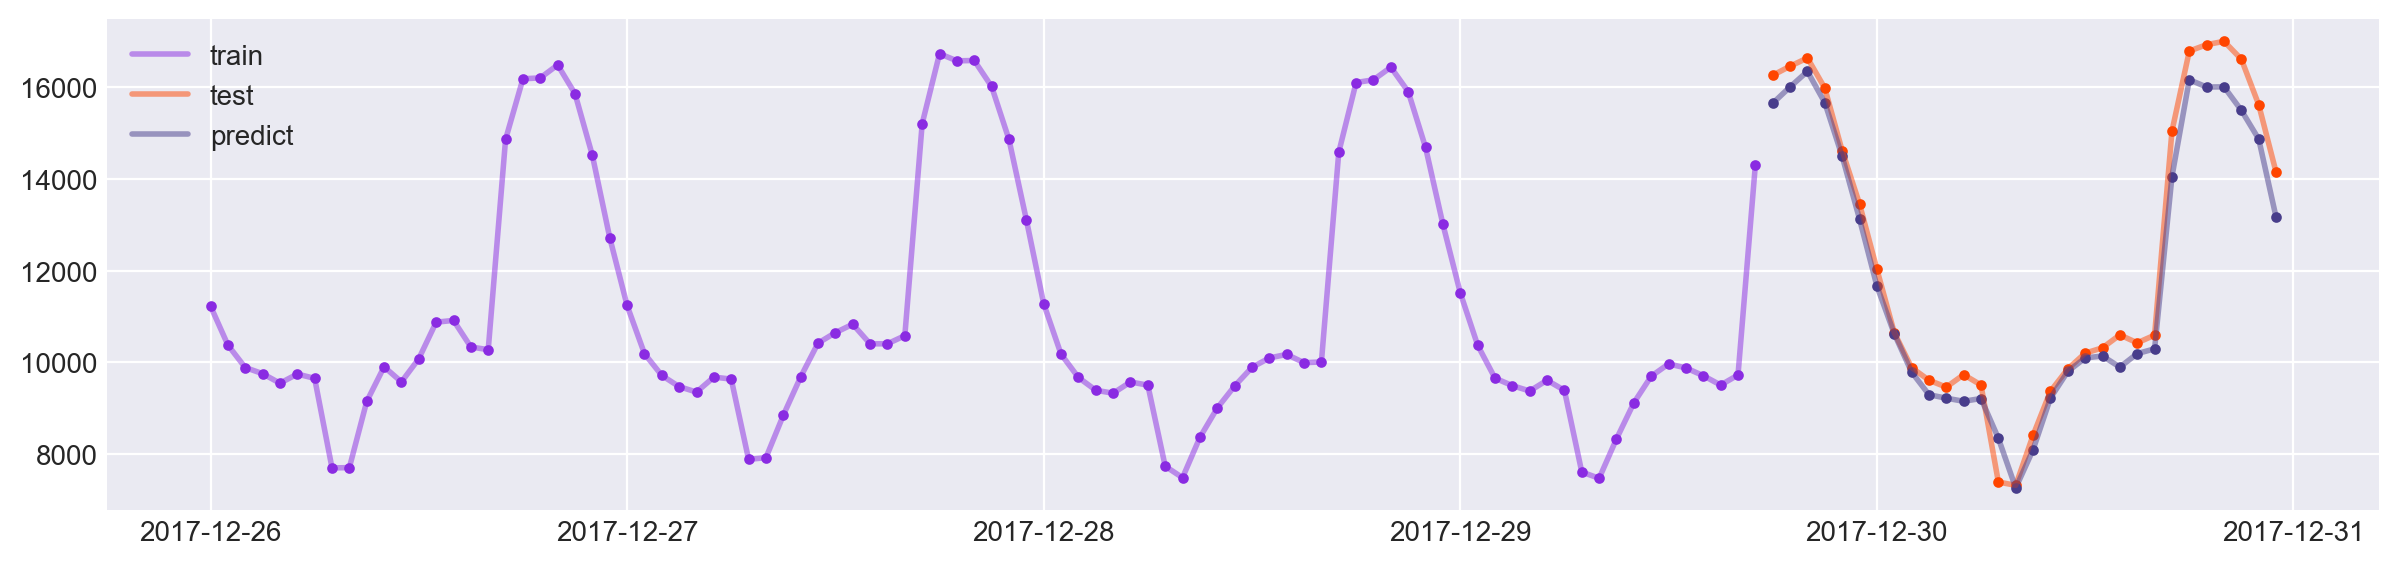

In [24]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

In [25]:
print(grid_search_results["params"])

{'l2_leaf_reg': 3}


In [26]:
del (
    train_x,
    train_y,
    test_x,
    test_y,
    train_pool,
    test_pool,
)

### Data Prep For LSTM

In [27]:
import tensorflow as tf


model, yhat, model_name = None, None, None

model_name = "LSTM_Dense"

WINDOW_LEN = 24
BATCH_SIZE = 64
BUFFER_SIZE = 100
EPOCHS_ = 15


def window_data(X_data, y_data, window_len=7):
    x_, y_ = [], []
    for i in range(window_len - 1, len(X_data)):
        x_.append(X_data[i - window_len + 1 : i + 1])
        y_.append(y_data[i])
    return np.array(x_), np.array(y_)


print(f"dataframe shape {dataframe.shape}")

build_features = lambda df: (
    df.pipe(create_lag_feature, column=TARGET_COLUMN, lags=LAGS)
    .pipe(create_window_feature, column=TARGET_COLUMN, window_len=FEATURE_WINDOW_LEN)
    .pipe(create_datetime_feature, features_name=DT_FEATURES)
    .pipe(create_cyclic_feature, features_name=CYCLIC_FEATURE)
    .pipe(drop_null_rows)
)

df_feat = build_features(dataframe)

print(f"dataframe shape after Feature Union {df_feat.shape}", end="\n\n")

data_x, data_y = seperate_target(df_feat, TARGET_COLUMN)

print(f"data_x shape after seperate_target {data_x.shape}")
print(f"data_y shape after seperate_target {data_y.shape}", end="\n\n")

scaler_x = StandardScaler()
scaler_x.fit(data_x)
data_x_np = scaler_x.transform(data_x)

scaler_y = StandardScaler()
scaler_y.fit(data_y)
data_y_np = scaler_y.transform(data_y)

print(f"data_x shape after StandardScaler {data_x_np.shape}")
print(f"data_y shape after StandardScaler {data_y_np.shape}", end="\n\n")

x_window, y_window = window_data(data_x_np, data_y_np, window_len=WINDOW_LEN)

print(f"x_window shape after Windowing {x_window.shape}")
print(f"y_window shape after Windowing {y_window.shape}", end="\n\n")

x_train_data, x_test_data = x_window[:-TEST_SIZE], x_window[-TEST_SIZE:]
y_train_data, y_test_data = y_window[:-TEST_SIZE], y_window[-TEST_SIZE:]

print(f"x_train_data shape after Test Train Split {x_train_data.shape}")
print(f"x_test_data  shape after Test Train Split {x_test_data.shape}")
print(f"y_train_data shape after Test Train Split {y_train_data.shape}")
print(f"y_test_data  shape after Test Train Split {y_test_data.shape}", end="\n\n")

train_data = (
    tf.data.Dataset.from_tensor_slices((x_train_data, y_train_data))
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
)


test_data = (
    tf.data.Dataset.from_tensor_slices((x_test_data, y_test_data))
    .batch(BATCH_SIZE)
    .repeat()
)

dataframe shape (1825, 8)
dataframe shape after Feature Union (1822, 27)

data_x shape after seperate_target (1822, 26)
data_y shape after seperate_target (1822, 1)

data_x shape after StandardScaler (1822, 26)
data_y shape after StandardScaler (1822, 1)

x_window shape after Windowing (1799, 24, 26)
y_window shape after Windowing (1799, 1)

x_train_data shape after Test Train Split (1769, 24, 26)
x_test_data  shape after Test Train Split (30, 24, 26)
y_train_data shape after Test Train Split (1769, 1)
y_test_data  shape after Test Train Split (30, 1)



In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = tf.keras.models.Sequential(
    [
        LSTM(64, input_shape=x_window.shape[-2:], dropout=0.0, activation="relu"),
        Dense(64, activation="relu"),
        Dense(64, activation="relu"),
        Dense(1),
    ]
)

model.compile(optimizer="adam", loss="mse", metrics="mae")

training_history = model.fit(
    train_data,
    epochs=25,
    steps_per_epoch=200,
    validation_data=test_data,
    validation_steps=50,
)
yhat = model.predict(x_test_data)
print(yhat.shape)

Epoch 1/25
200/200 [==============================] - 7s 23ms/step - loss: 0.2748 - mae: 0.3917 - val_loss: 0.1015 - val_mae: 0.2598
Epoch 2/25
200/200 [==============================] - 4s 22ms/step - loss: 0.0836 - mae: 0.2207 - val_loss: 0.0617 - val_mae: 0.2106
Epoch 3/25
200/200 [==============================] - 4s 21ms/step - loss: 0.0650 - mae: 0.1955 - val_loss: 0.0939 - val_mae: 0.2440
Epoch 4/25
200/200 [==============================] - 5s 23ms/step - loss: 0.0576 - mae: 0.1859 - val_loss: 0.1281 - val_mae: 0.3206
Epoch 5/25
200/200 [==============================] - 5s 23ms/step - loss: 0.0396 - mae: 0.1505 - val_loss: 0.0540 - val_mae: 0.1891
Epoch 6/25
200/200 [==============================] - 5s 23ms/step - loss: 0.0253 - mae: 0.1189 - val_loss: 0.0373 - val_mae: 0.1437
Epoch 7/25
200/200 [==============================] - 4s 21ms/step - loss: 0.0385 - mae: 0.1496 - val_loss: 0.0495 - val_mae: 0.1687
Epoch 8/25
200/200 [==============================] - 5s 23ms/step - 

In [29]:
yhat_scaled = scaler_y.inverse_transform(yhat)
y_test_data_scaled = scaler_y.inverse_transform(y_test_data)
y_train_data_scaled = scaler_y.inverse_transform(y_train_data)


print(f"yhat_scaled shape {yhat_scaled.shape} {y_test_data_scaled.shape}")
resultsDict[model_name] = evaluate(y_test_data_scaled, yhat_scaled)

yhat_scaled shape (30, 1) (30, 1)


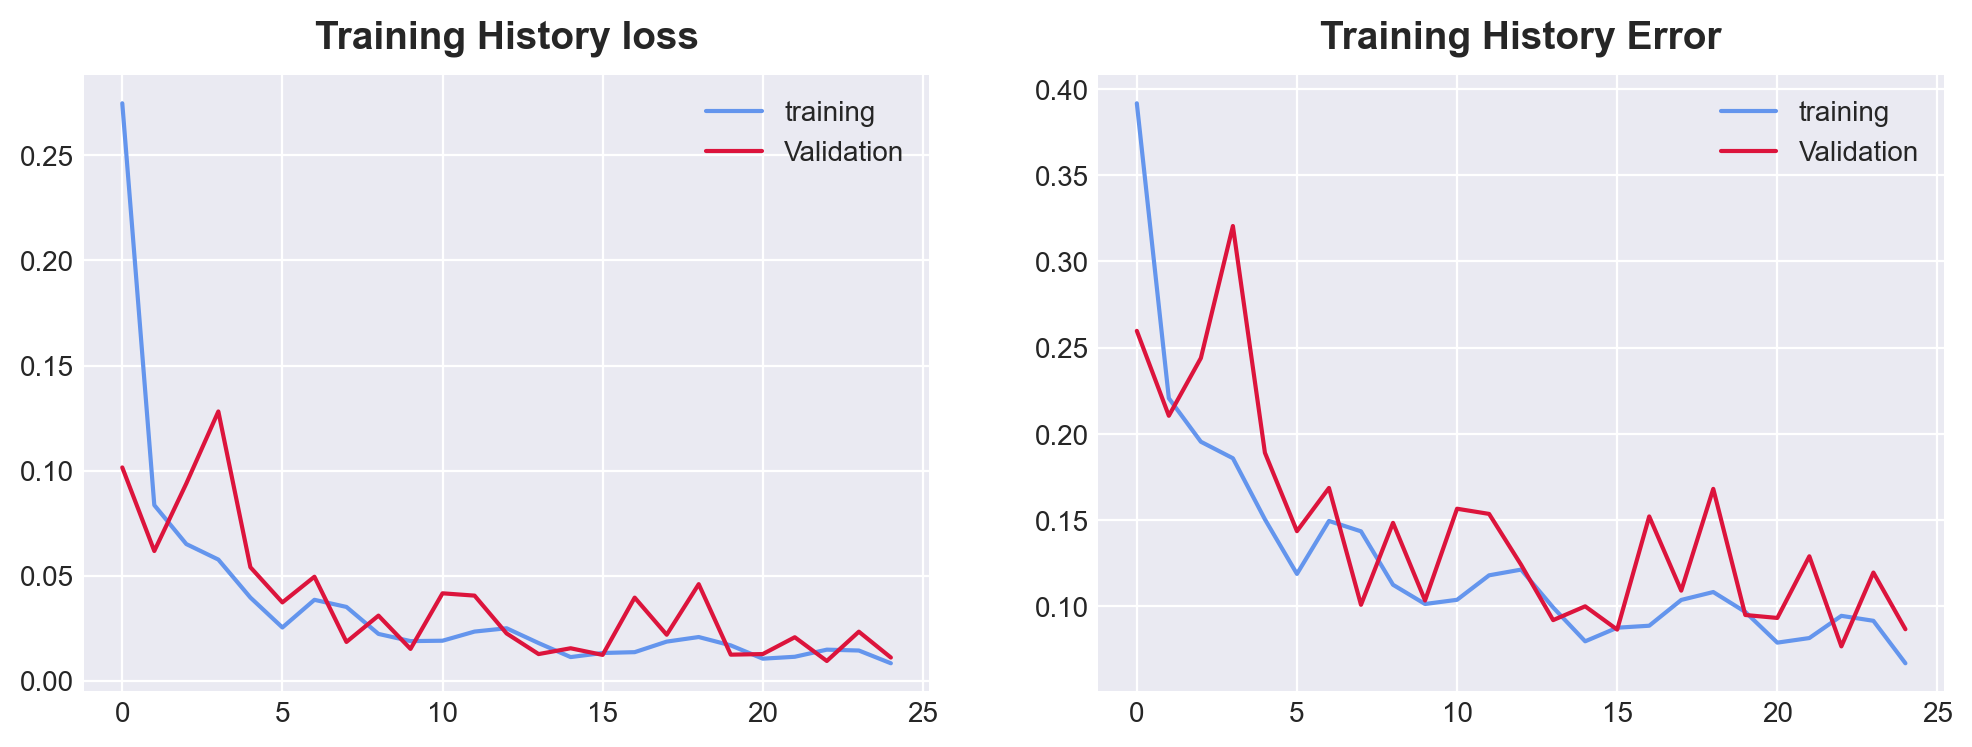

In [30]:
plot_tf_training_history(training_history)

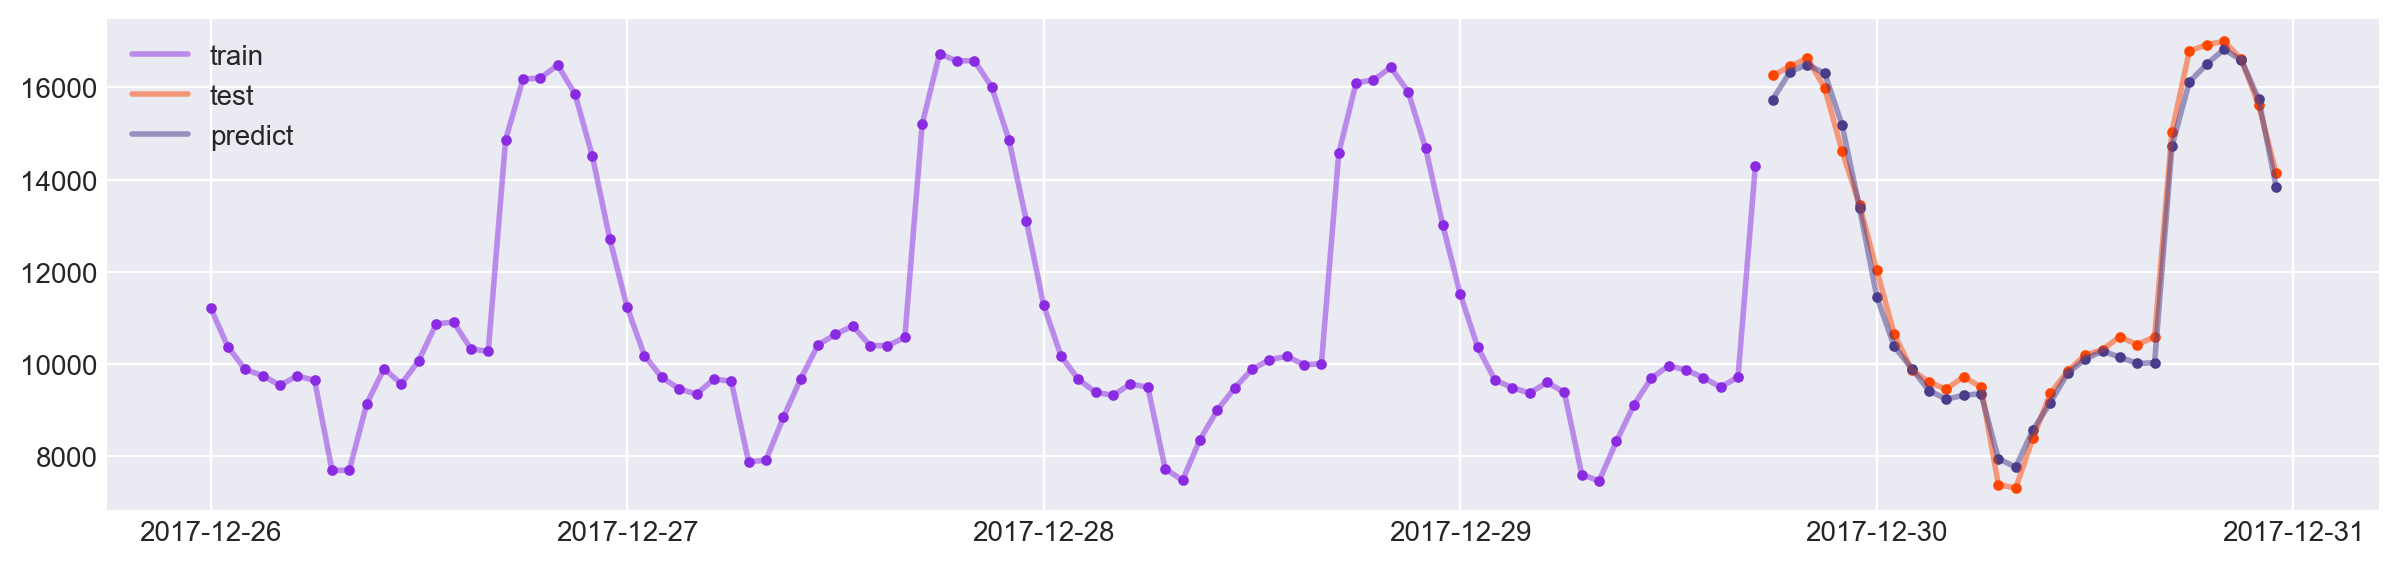

In [31]:
y_hat_df = pd.DataFrame(
    yhat_scaled, index=data_y.index[-TEST_SIZE:], columns=["TARGET_COLUMN"]
)

y_test_data_df = pd.DataFrame(
    y_test_data_scaled, index=data_y.index[-TEST_SIZE:], columns=["TARGET_COLUMN"]
)

y_train_data_df = pd.DataFrame(
    y_train_data_scaled,
    index=data_y.index[WINDOW_LEN - 1 : -TEST_SIZE],
    columns=["TARGET_COLUMN"],
)

show_series(
    [y_train_data_df[-90:], y_test_data_df, y_hat_df],
    labels=["train", "test", "predict"],
)

In [32]:
resultsDF = pd.DataFrame.from_dict(resultsDict)
resultsDF.head()

,KNeighborsRegressor,BayesianRidge,LassoCV,RandomForestRegressor,XGBRegressor,LGBMRegressor,CatBoostRegressor,LSTM_Dense
mae,798.207283,431.528626,450.628410,261.740314,376.240681,338.489809,448.976713,283.566898
rmse,1123.596893,741.774506,763.598982,353.537688,468.018641,405.905523,557.125402,342.936446
mape,0.068712,0.037205,0.039094,0.023995,0.031915,0.029668,0.035595,0.024641
r2,0.878066,0.946857,0.943684,0.987928,0.978844,0.984087,0.970022,0.988641


In [33]:
resultsDF.T

,mae,rmse,mape,r2
KNeighborsRegressor,798.207283,1123.596893,0.068712,0.878066
BayesianRidge,431.528626,741.774506,0.037205,0.946857
LassoCV,450.628410,763.598982,0.039094,0.943684
RandomForestRegressor,261.740314,353.537688,0.023995,0.987928
XGBRegressor,376.240681,468.018641,0.031915,0.978844
LGBMRegressor,338.489809,405.905523,0.029668,0.984087
CatBoostRegressor,448.976713,557.125402,0.035595,0.970022
LSTM_Dense,283.566898,342.936446,0.024641,0.988641


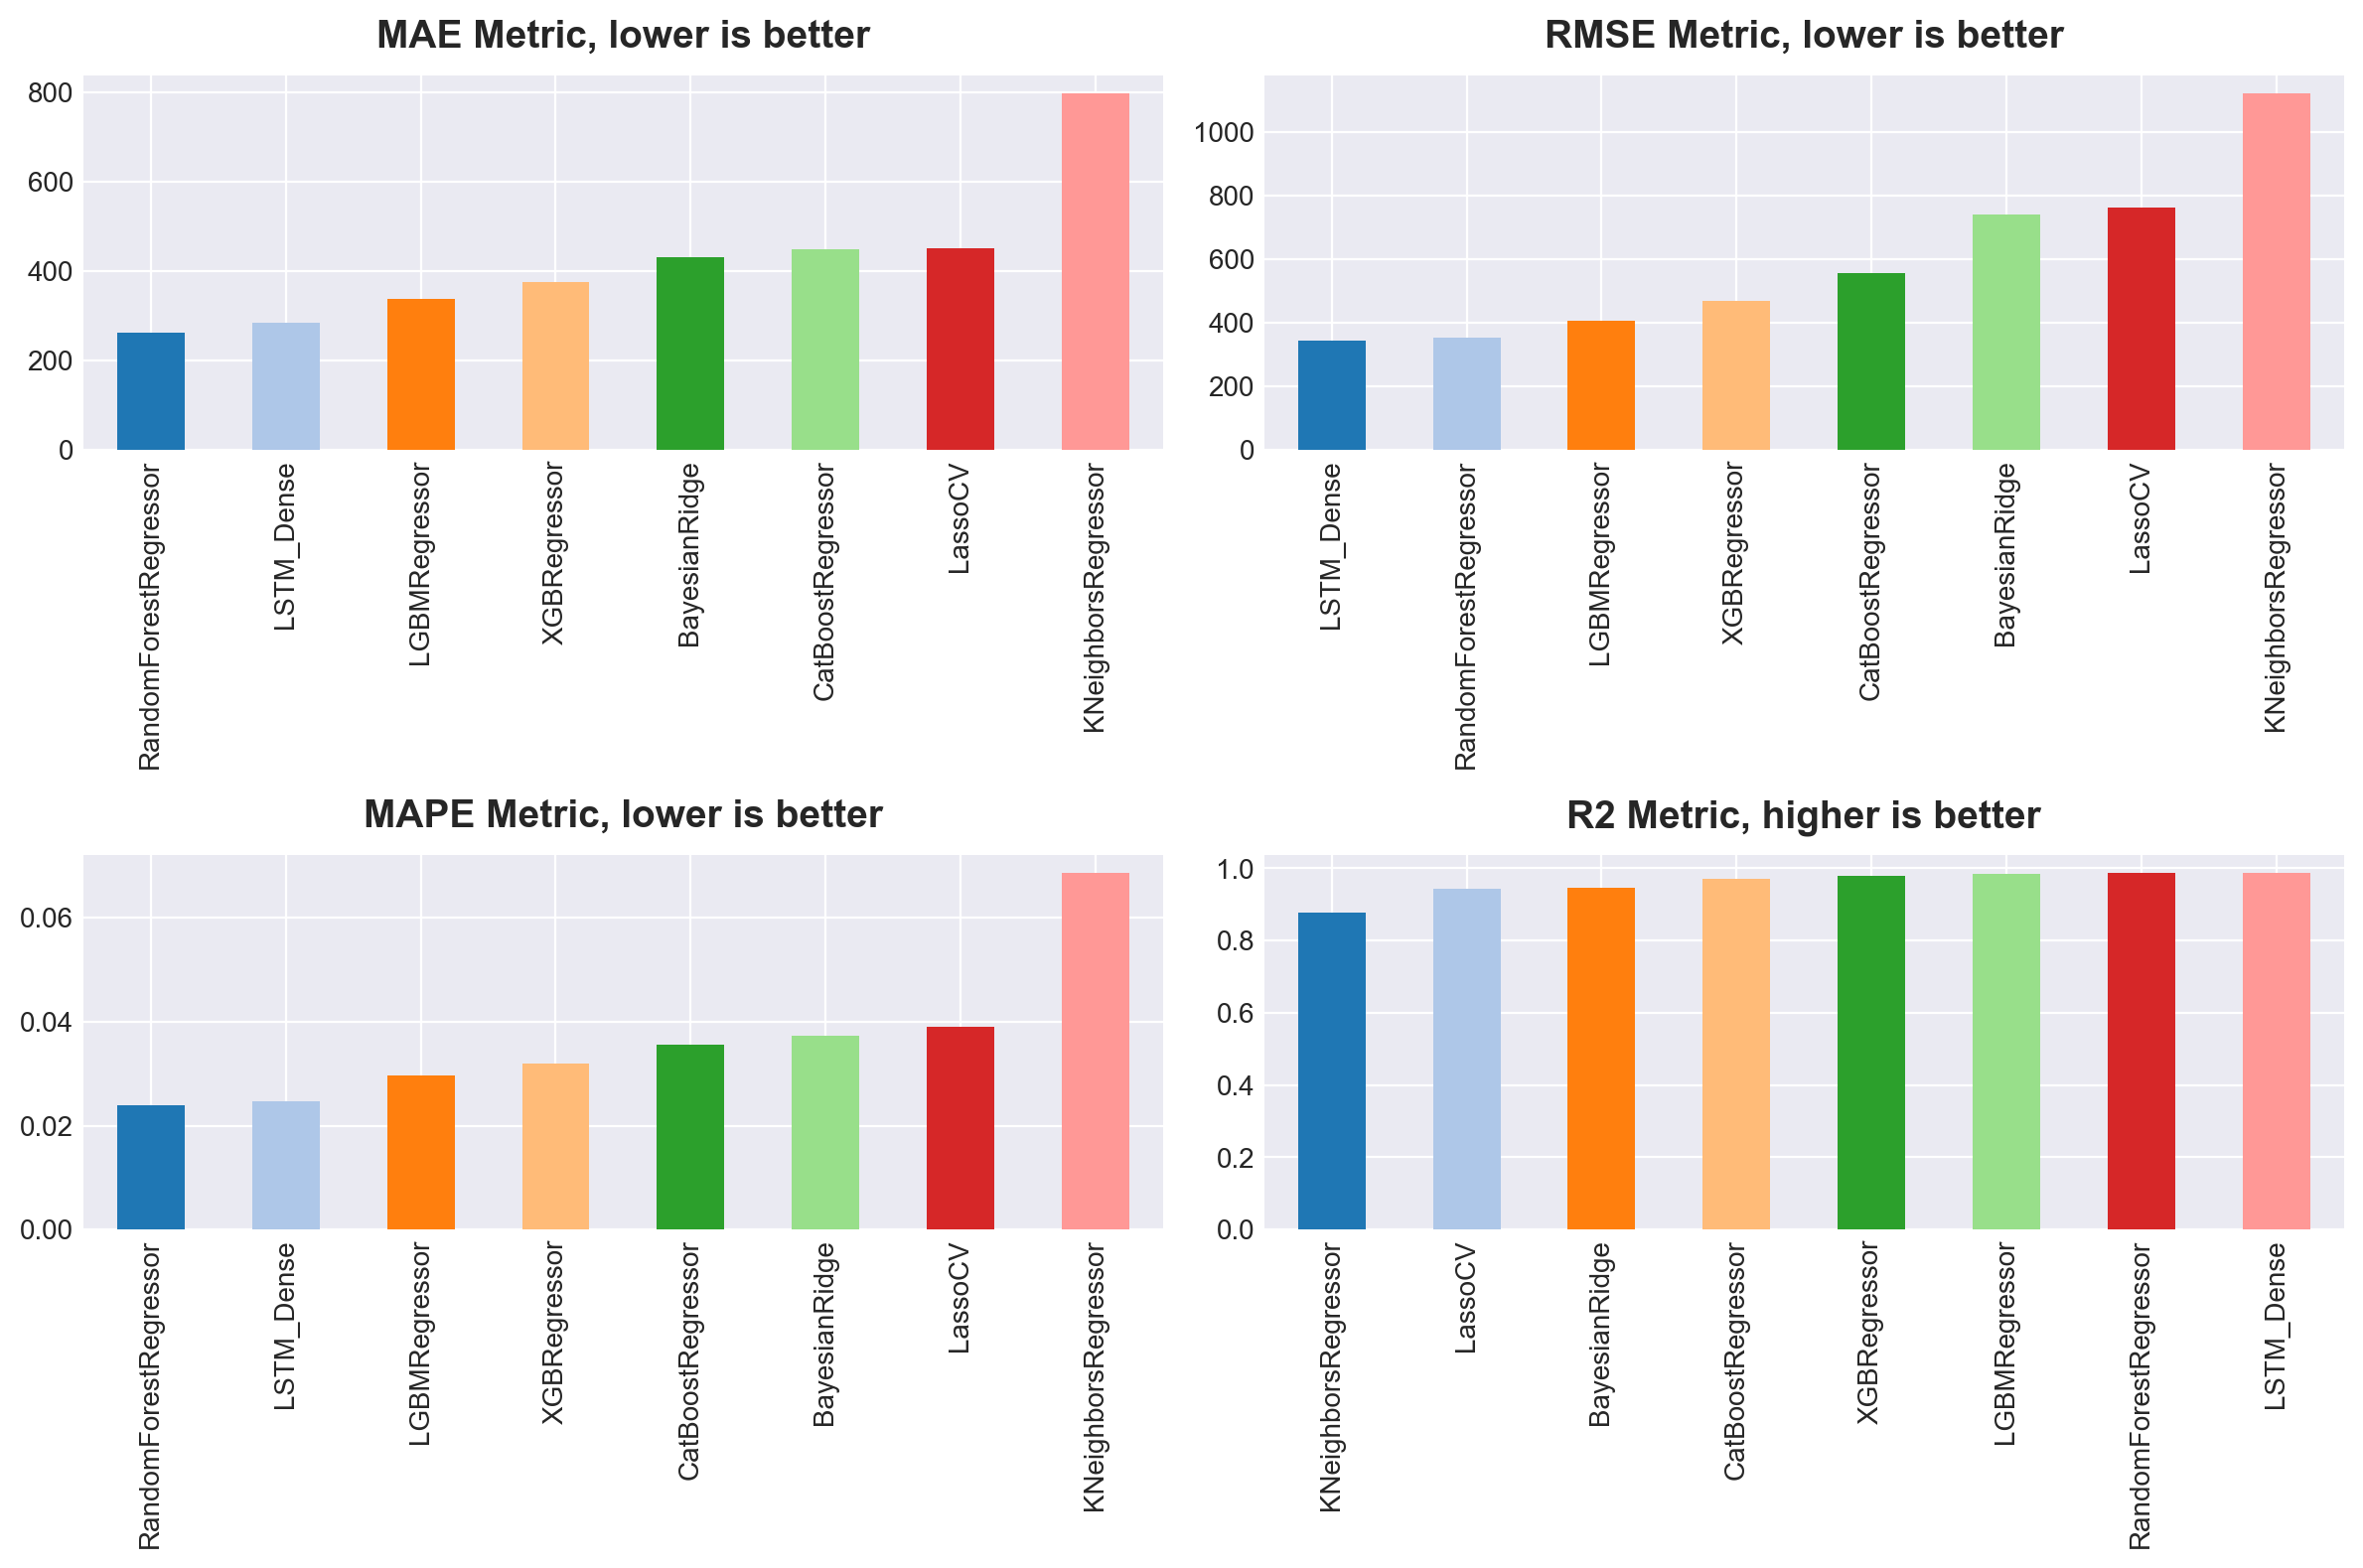

In [34]:
plot_metrics(resultsDF)

In [35]:
resultsDF_T = resultsDF.T.copy(deep=True)
resultsDF_T["Dataset"] = "Power_consumption"
resultsDF_T["Mode"] = "Singel_step"

result_path = "./results/results.csv"

if os.path.isfile(result_path) is False:
    resultsDF_T.to_csv(result_path, index=False)
else:
    result_data = pd.read_csv(result_path)
    if result_data[result_data["Dataset"] == "Power_consumption"].shape[0] > 0:
        result_data = result_data[result_data["Dataset"] != "Power_consumption"].copy()

    new_data = pd.concat([result_data, resultsDF_T])
    new_data.to_csv(result_path, index=False)